In [2]:
import pandas as pd
import numpy as np
from time import sleep
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import MinMaxScaler
import math
from scipy.special import i0 
from numpy.random import vonmises
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.mixture import GaussianMixture


import warnings
# warning.filterwarnings('ignore')

In [3]:
# set postseason date
today_y = 2019
today_m = 3
today_d = 1
d2 = datetime(today_y, today_m, today_d)

def get_age(bday, d2=d2):
    if '-' in bday:
        dash1 = bday.find('-')
        y = int(bday[:dash1])
        rest = bday[dash1+1:] 
        dash2 = rest.find('-') 
        m = int(rest[:dash2])
        d = int(rest[dash2+1:])
    else:
        slash1 = bday.find('/')
        m = int(bday[:slash1])
        rest = bday[slash1+1:]
        slash2 = rest.find('/')
        d = int(rest[:slash2])
        y = int(rest[slash2+1:])
    d1 = datetime(y, m, d)
    return relativedelta(d2, d1).years

In [4]:
# https://stackoverflow.com/questions/28839246/scipy-gaussian-kde-and-circular-data
def vonmises_kde(data, kappa, n_bins=100):
    bins = np.linspace(-np.pi, np.pi, n_bins)
    x = np.linspace(-np.pi, np.pi, n_bins)
    # integrate vonmises kernels
    kde = np.exp(kappa*np.cos(x[:, None]-data[None, :])).sum(1)/(2*np.pi*i0(kappa))
    kde /= np.trapz(kde, x=bins)
    return bins, kde

In [5]:
# get angle between two vectors
def get_angle(x1, y1, x2, y2, x3, y3, x4, y4):
    a_x = x2 - x1
    a_y = y2 - y1
    b_x = x4 - x3
    b_y = y4 - y3 
    numerator = a_x * b_x + a_y * b_y
    denom = math.sqrt(a_x**2 + a_y**2) * math.sqrt(b_x**2 + b_y**2) 
    return math.degrees(math.acos(1.0 * numerator / denom))

In [6]:
# distance formula
def dist(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [7]:
# prepares x, y for DataLoader
class data_set():
    def __init__(self, x, Y, idxList=None):
        self.x = x
        self.Y = Y
        if idxList is not None:
            self.idxList = idxList
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return [self.x[idx], self.Y[idx]]

In [8]:
coverages = pd.read_csv('coverages_week1.csv')
games = pd.read_csv('games.csv')
plays = pd.read_csv('plays.csv') # playId is NOT unique (need gameId too)
targets = pd.read_csv('targetedReceiver.csv')
players = pd.read_csv('players.csv')

In [9]:
tracking = pd.concat([pd.read_csv(str('week'+str(i)+'.csv')) for i in list(range(1, 18))], ignore_index=True) # read and concat all tracking files

In [10]:
plays = plays.query('isDefensivePI==False') # exclude DPI
plays = plays.query('penaltyCodes != penaltyCodes') # exclude all penalties
plays = plays[~plays.personnelO.str.contains('2 QB')] # contains 2 QBs
plays = plays[~plays.personnelO.str.contains('1 K')] # contains kicker 
plays = plays[~plays.personnelO.str.contains('1 P')] # contains kicker 
plays = plays[~plays.personnelO.str.contains('DL')] # contains DL
plays = plays[~plays.personnelO.str.contains('DB')] # contains DB
complete_plays = plays[plays['passResult']=='C'][['gameId', 'playId']] # complete passes
incomplete_plays = plays[plays['passResult']=='I'][['gameId', 'playId']] # incomplete passes
all_plays = plays[plays['passResult'].isin(['C', 'I'])][['gameId', 'playId']] # complete and incomplete passes

In [11]:
# INNER JOIN w/ play data, removes unrepresentative plays identified above
tracking = pd.merge(tracking, all_plays, how='inner', on=['gameId', 'playId'])

# standardize tracking data so on all plays, offense moves right
tracking['x'] = np.where(tracking['playDirection']=='left', 120-tracking['x'], tracking['x'])
tracking['y'] = np.where(tracking['playDirection']=='left', 53.3-tracking['y'], tracking['y'])

In [13]:
tracking.event.unique() 

array(['None', 'ball_snap', 'pass_forward', 'pass_arrived',
       'pass_outcome_caught', 'out_of_bounds', 'pass_outcome_incomplete',
       'first_contact', 'tackle', 'man_in_motion', 'play_action',
       'handoff', 'pass_tipped', 'pass_shovel', 'line_set', 'shift',
       'touchdown', 'fumble', 'fumble_defense_recovered',
       'pass_outcome_touchdown', 'fumble_offense_recovered',
       'penalty_flag', 'penalty_accepted', 'qb_spike',
       'field_goal_blocked', 'snap_direct', 'run_pass_option',
       'pass_lateral', 'lateral', 'huddle_start_offense',
       'huddle_break_offense', 'qb_strip_sack', 'timeout_home',
       'touchback', 'qb_sack'], dtype=object)

In [14]:
players['age'] = np.vectorize(get_age)(players['birthDate'])

players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName,age
0,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant,28
1,2539653,70,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford,30
2,2543850,69,186,1991-12-18,Purdue,SS,Ricardo Allen,27
3,2555162,73,227,1994-11-04,Louisiana State,MLB,Deion Jones,24
4,2555255,75,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell,25


# E[COMPLETION % | RECEIVER]

In [15]:
# snapshot of time of throw
pass_forward = tracking.query('event=="pass_forward"')

# snapshot of time of throw (complete)
comp_pass_forward = pd.merge(pass_forward, complete_plays, how='inner', 
                             on=['gameId', 'playId'])[['x', 'y', 's', 'a', 'o', 'dir', 'nflId', 'displayName', 'position', 'frameId', 'team', 'gameId', 'playId', 'route']]

# snapshot of time of throw (incomplete)
inc_pass_forward = pd.merge(pass_forward, incomplete_plays, how='inner',
                           on=['gameId', 'playId'])[['x', 'y', 's', 'a', 'o', 'dir', 'nflId', 'displayName', 'position', 'frameId', 'team', 'gameId', 'playId', 'route']]

# completed pass plays w/ 5+ players tracked from both teams
fivePlus_complete_plays = comp_pass_forward[['nflId', 'team', 'gameId', 
                                             'playId']].query('team != "football"').groupby(['gameId', 'playId', 'team'], 
                                                                                               as_index=False).aggregate('count').pivot_table(index=['gameId', 'playId'], 
                                                                                                                                              columns='team', 
                                                                                                                                              values='nflId'
                                                                                                                                             ).reset_index().query('away>5&home>5')[['gameId', 'playId']]

# label plays as completed passes
fivePlus_complete_plays['ci'] = 1

# incomplete pass plays w/ 5+ players tracked from both teams
fivePlus_inc_plays = inc_pass_forward[['nflId', 'team', 'gameId', 
                 'playId']].query('team!="football"').groupby(['gameId', 'playId', 'team'],
                                                             as_index=False).aggregate('count').pivot_table(index=['gameId', 'playId'],
                                                                                                           columns='team',
                                                                                                           values='nflId'
                                                                                                           ).reset_index().query('away>5&home>5')[['gameId', 'playId']]
# label plays as incomplete passes
fivePlus_inc_plays['ci'] = 0
fivePlus_inc_plays.head()

team,gameId,playId,ci
0,2018090600,146,0
1,2018090600,168,0
3,2018090600,344,0
4,2018090600,402,0
5,2018090600,545,0


In [16]:
# all plays w/ 5+ offensive and defensive players tracked
fivePlus_all = pd.concat([fivePlus_complete_plays, fivePlus_inc_plays], ignore_index=True) 

# tracking data for all plays w/ 5+ offensive and defensive players tracked
fivePlus_tracking = pd.concat([pd.merge(comp_pass_forward.query('team!="football"'), fivePlus_complete_plays, how='inner', on=['gameId', 'playId']), 
           pd.merge(inc_pass_forward.query('team!="football"'), fivePlus_inc_plays, how='inner', on=['gameId', 'playId'])], ignore_index=True)

# round tracking data to 2 decimals
fivePlus_tracking.y = fivePlus_tracking.y.round(2)

# merge tracking data w/ ID of targeted WR
fivePlus_tracking = pd.merge(fivePlus_tracking, targets, how='inner', on=['gameId', 'playId']) 

# new feature to identify targeted WR
fivePlus_tracking['isTarget'] = np.where(fivePlus_tracking['targetNflId']==fivePlus_tracking['nflId'], 1, 0)

# subset to targeted WR
target1 = fivePlus_tracking.query('isTarget==1')[['gameId', 'playId', 'team']]

# rename columns to define team on offense
target1.columns = ['gameId', 'playId', 'off_team']

# merge with tracking data 
fivePlus_tracking = pd.merge(fivePlus_tracking, target1, how='inner', on=['gameId', 'playId'])

# new feature to identify offensive team
fivePlus_tracking['isOff'] = np.where(fivePlus_tracking['off_team']==fivePlus_tracking['team'], 1, 0)

# make deep copy
fivePlus_tracking2 = fivePlus_tracking.copy()

# mirror each play to double size of data for NN training purposes
fivePlus_tracking2['y'] = 53.3 - fivePlus_tracking2['y']

fivePlus_tracking.head()

,x,y,s,a,o,dir,nflId,displayName,position,frameId,team,gameId,playId,route,ci,targetNflId,isTarget,off_team,isOff
0,23.57,26.52,0.84,2.05,356.40,333.39,310.0,Matt Ryan,QB,36,away,2018090600,75,NaN,1,2495454.0,0,away,1
1,35.18,14.97,5.53,4.30,295.34,318.58,79848.0,Malcolm Jenkins,SS,36,home,2018090600,75,NaN,1,2495454.0,0,away,0
2,39.31,8.39,3.11,6.67,155.11,297.88,2495454.0,Julio Jones,WR,36,away,2018090600,75,HITCH,1,2495454.0,1,away,1
3,33.98,34.66,3.52,0.69,28.19,216.15,2495613.0,Corey Graham,FS,36,home,2018090600,75,NaN,1,2495454.0,0,away,0
4,37.35,18.74,6.35,1.21,262.06,272.78,2533040.0,Mohamed Sanu,WR,36,away,2018090600,75,HITCH,1,2495454.0,0,away,1


In [16]:
%%time
# holds input tensors for each play (key = 'gameId_playId')
completion_dict = {} 

# hold pass outcome (key = 'gameId_playId')
comp_y_dict = {}

# number of plays in set
n_total = fivePlus_all.shape[0]

# deciles
n9 = list(np.round(np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1])*n_total))

# starter
n_now = 0

## closest defender to WR @ ToT or pass incomplete or pass complete
comp_closest_pID = []
comp_closest_gID = [] 
comp_closest_playerID = []
comp_targetID = []

for i in range(n_total):
    if i+1 in n9:
        n_now += 1
        print(str(n_now)+'0% DONE')
    play_i = fivePlus_all.iloc[i] # subset to play
    g_i = play_i['gameId'] # get gameID
    p_i = play_i['playId'] # get playID
    frame_i = fivePlus_tracking[(fivePlus_tracking['gameId']==g_i) & (fivePlus_tracking['playId']==p_i)] # subset tracking data to game_i, play_i
    target_i = frame_i.query('isTarget==1') # get target info
    ntarget_i = frame_i.query('isTarget==0') # get other players info
    if target_i.shape[0]==1: # make sure target is defined on play
        t_x = float(target_i['x']) # target x
        t_y = float(target_i['y']) # target y
        t_s = float(target_i['s']) # target speed
        off_i = ntarget_i.query('isOff==1')[['x', 'y', 's']] # subset offense
        def_i = ntarget_i.query('isOff==0')[['x', 'y', 's', 'nflId']] # subset defense
        def_i['def_target_dist'] = np.vectorize(dist)(def_i['x'], def_i['y'], t_x, t_y) # defender to targeted WR distance
        def_i['def_target_s'] = np.abs(def_i['s'] - t_s) # absolute speed difference b/t defender and targeted WR
        def_i = def_i.sort_values(by='def_target_dist') # sort defenders by distance to targeted WR 
        
        comp_closest_pID.append(p_i)
        comp_closest_gID.append(g_i)
        comp_closest_playerID.append(def_i.iloc[0,]['nflId'])
        comp_targetID.append(target_i.iloc[0,]['nflId'])
        
        off_i['off_target_dist'] = np.vectorize(dist)(off_i['x'], off_i['y'], t_x, t_y) # offensive player to targeted WR distance
        off_i = off_i.sort_values(by='off_target_dist') # sort offensive players by distance to targeted WR
        arr_i = np.zeros((5, 5, 6), dtype=float) # (feature, offensive player, defensive player)
        arr_i[0,:,:] = np.array(list(def_i.s)[:6]*5).reshape(5,6) # defender speed
        arr_i[1,:,:] = np.array(list(def_i.def_target_dist)[:6]*5).reshape(5,6) # defender dist from target WR
        arr_i[2,:,:] = np.array(list(def_i.def_target_s)[:6]*5).reshape(5,6) # defender speed relative to target WR
        for o in range(5): # take 5 closest offensive players to targeted WR if > 5
            for d in range(6): # take 5 closest defensive players to targeted WR if > 5
                arr_i[3,o,d] = float(dist(off_i.iloc[o,]['x'], off_i.iloc[o,]['y'], def_i.iloc[d,]['x'], def_i.iloc[d,]['y'])) # distance b/t each offensive/defensive player
                arr_i[4,o,d] = float(np.abs(off_i.iloc[o,]['s'] - def_i.iloc[d,]['s'])) # difference in speed b/t each offensive/defensive player 
        completion_dict[str(str(g_i)+'_'+str(p_i))] = arr_i # store 3D array for NN input
        comp_y_dict[str(str(g_i)+'_'+str(p_i))] = frame_i.iloc[0,:]['ci'] # store pass outcome 

10% DONE
20% DONE
30% DONE
40% DONE
50% DONE
60% DONE
70% DONE
80% DONE
90% DONE
100% DONE
CPU times: user 8min 56s, sys: 5.52 s, total: 9min 2s
Wall time: 9min 17s


In [17]:
%%time
# holds input tensors for each play (key = 'gameId_playId')
completion_dict2 = {} 

# hold pass outcome (key = 'gameId_playId')
comp_y_dict2 = {}

# starter
n_now = 0

for i in range(n_total):
    if i+1 in n9:
        n_now += 1
        print(str(n_now)+'0% DONE')
    play_i = fivePlus_all.iloc[i] # subset to play
    g_i = play_i['gameId'] # get gameID
    p_i = play_i['playId'] # get playID
    frame_i = fivePlus_tracking2[(fivePlus_tracking2['gameId']==g_i) & (fivePlus_tracking2['playId']==p_i)] # subset tracking data to game_i, play_i
    target_i = frame_i.query('isTarget==1') # get target info
    ntarget_i = frame_i.query('isTarget==0') # get other players info
    if target_i.shape[0]==1: # make sure target is defined on play
        t_x = float(target_i['x']) # target x
        t_y = float(target_i['y']) # target y
        t_s = float(target_i['s']) # target speed
        off_i = ntarget_i.query('isOff==1')[['x', 'y', 's']] # subset offense
        def_i = ntarget_i.query('isOff==0')[['x', 'y', 's']] # subset defense
        def_i['def_target_dist'] = np.vectorize(dist)(def_i['x'], def_i['y'], t_x, t_y) # defender to targeted WR distance
        def_i['def_target_s'] = np.abs(def_i['s'] - t_s) # absolute speed difference b/t defender and targeted WR
        def_i = def_i.sort_values(by='def_target_dist') # sort defenders by distance to targeted WR 
        off_i['off_target_dist'] = np.vectorize(dist)(off_i['x'], off_i['y'], t_x, t_y) # offensive player to targeted WR distance
        off_i = off_i.sort_values(by='off_target_dist') # sort offensive players by distance to targeted WR
        arr_i = np.zeros((5, 5, 6), dtype=float) # (feature, offensive player, defensive player)
        arr_i[0,:,:] = np.array(list(def_i.s)[:6]*5).reshape(5,6) # defender speed
        arr_i[1,:,:] = np.array(list(def_i.def_target_dist)[:6]*5).reshape(5,6) # defender dist from target WR
        arr_i[2,:,:] = np.array(list(def_i.def_target_s)[:6]*5).reshape(5,6) # defender speed relative to target WR
        for o in range(5): # take 5 closest offensive players to targeted WR if > 5
            for d in range(6): # take 5 closest defensive players to targeted WR if > 5
                arr_i[3,o,d] = float(dist(off_i.iloc[o,]['x'], off_i.iloc[o,]['y'], def_i.iloc[d,]['x'], def_i.iloc[d,]['y'])) # distance b/t each offensive/defensive player
                arr_i[4,o,d] = float(np.abs(off_i.iloc[o,]['s'] - def_i.iloc[d,]['s'])) # difference in speed b/t each offensive/defensive player 
        completion_dict2[str(str(g_i)+'_'+str(p_i))] = arr_i # store 3D array for NN input
        comp_y_dict2[str(str(g_i)+'_'+str(p_i))] = frame_i.iloc[0,:]['ci'] # store pass outcome 

10% DONE
20% DONE
30% DONE
40% DONE
50% DONE
60% DONE
70% DONE
80% DONE
90% DONE
100% DONE
CPU times: user 8min 44s, sys: 5.4 s, total: 8min 49s
Wall time: 8min 57s


In [18]:
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv21 = nn.Sequential(nn.Conv2d(5, 8, kernel_size=2, stride=1),
                                  nn.LeakyReLU())
        self.conv22 = nn.Sequential(nn.Conv2d(8, 16, kernel_size=2, stride=1),
                                   nn.LeakyReLU())
        self.conv23 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=2, stride=1),
                                   nn.LeakyReLU(),
                                   nn.AvgPool2d(kernel_size=2, stride=1))
        self.conv11 = nn.Sequential(nn.Conv1d(4, 8, kernel_size=2, stride=1),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(num_features=8))
        self.conv12 = nn.Sequential(nn.Conv1d(8, 16, kernel_size=2, stride=1),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(num_features=16))
        self.conv13 = nn.Sequential(nn.Conv1d(16, 32, kernel_size=2, stride=1),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(num_features=32),
                                   nn.AvgPool1d(kernel_size=2, stride=1))
        self.lin1 = nn.Sequential(nn.Linear(896, int(256)),
                                  nn.Dropout(0.3), 
                                    nn.LeakyReLU(),
                                 nn.BatchNorm1d(num_features=int(256)))
        self.lin11 = nn.Sequential(nn.Linear(384, int(64/2)),
                                  nn.Dropout(0.3), 
                                    nn.LeakyReLU(),
                                 nn.BatchNorm1d(num_features=int(64/2)))
        self.lin2 = nn.Sequential(nn.Linear(int(64/2), 1),
#                                   nn.Dropout(0.3),
                                 nn.LeakyReLU(),
                                 nn.BatchNorm1d(num_features=1))
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv21(x)
        x = self.conv22(x) 
        x = self.conv23(x)
#         print(x.shape)
        x = x.view(x.size(0), 4, 16)
#         print(x.shape)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = x.view(x.size(0), -1)
#         print(x.shape)
#         x = self.lin1(x)
        x = self.lin11(x)
        x = self.lin2(x)
        x = self.sig(x)
        return x

compPctModel = Net()
optimizer = Adam(compPctModel.parameters(), lr=0.001)
criterion = nn.BCELoss()
print(compPctModel)

def train(model, epoch, L, tl, C):
    optimizer = Adam(model.parameters(), lr=L)
    model.train()
    tr_loss = 0
    for batch_idx, (train_data, train_target) in enumerate(tl):
        optimizer.zero_grad()

        output_train = model(train_data)

        loss_train = C(output_train, train_target.float())
        tr_loss += loss_train.item()
    
        loss_train.backward() 
        optimizer.step()

    if (epoch+1)%10==0: 
        avg_loss = tr_loss / (batch_idx+1)
        print('( LEARNING RATE =', L, ') EPOCH:', epoch+1, '| LOSS:', avg_loss)

Net(
  (conv21): Sequential(
    (0): Conv2d(5, 8, kernel_size=(2, 2), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv22): Sequential(
    (0): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv23): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=1, padding=0)
  )
  (conv11): Sequential(
    (0): Conv1d(4, 8, kernel_size=(2,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv12): Sequential(
    (0): Conv1d(8, 16, kernel_size=(2,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv13): Sequential(
    (0): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32

In [16]:
## DETERMINE OPTIMAL MODEL STRUCTURE

# get array of 3D NN inputs from actual/synthetic data
train_x = np.array([completion_dict[c] for c in list(completion_dict.keys())] + [completion_dict2[c] for c in list(completion_dict2.keys())])

# get array of pass outcomes from actual/synthetic data
train_y = np.array([comp_y_dict[c] for c in list(completion_dict.keys())] + [comp_y_dict2[c] for c in list(completion_dict2.keys())])

# train/test split all data
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.3, random_state=22)

# torch training X
train_x = torch.from_numpy(train_x.astype(np.float32))

# re-format training Y, torch
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

print(train_x.shape, train_y.shape) # depth of 5 for 5x6 array 

# torch test X
test_x = torch.from_numpy(test_x.astype(np.float32))

# re-format test Y, torch
test_y = test_y.astype(int)
test_y = torch.from_numpy(test_y)

# prepare training set DataLoader
trainX = data_set(train_x, train_y)
train_loader = torch.utils.data.DataLoader(trainX, batch_size=64, shuffle=True)

# prepare test set DataLoader
testX = data_set(test_x, test_y)
test_loader = torch.utils.data.DataLoader(testX, batch_size=64, shuffle=False)

n_epochs_list = [10, 20, 30] # number of EPOCHS
lr_list = [0.001, 0.0007] # possible learning rates
for lr_i in lr_list:
    for n_epochs in n_epochs_list:
        print('TOTAL EPOCHS:', n_epochs)
        compPctModel = Net() # define new model
        for epoch in range(n_epochs):
            train(model=compPctModel, epoch=epoch, L=lr_i, tl=train_loader, C=nn.BCELoss()) # train model on specified parameters

        test_loss = 0 # initialize test loss

        # run test set through model in batches
        for batch_idx, (test_data, test_target) in enumerate(test_loader):
            output_test = compPctModel(test_data)
            test_loss += criterion(output_test, test_target.float()).item() 

        avg_test_loss = test_loss / (batch_idx+1) # get avg loss from the test set 
        print('\n<TEST> ( LEARNING RATE =', lr_i, ') LOSS:', avg_test_loss, '\n') 

torch.Size([21758, 5, 5, 6]) torch.Size([21758])
TOTAL EPOCHS: 10


/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


KeyboardInterrupt: 

In [19]:
## GENERATE EXPECTED VALUES

# train/test split play/game ID keys
train_idx, test_idx = train_test_split(list(completion_dict.keys()), test_size=0.5, random_state=22)

# get array of 3D NN inputs from actual/synthetic data
train_x1 = np.array([completion_dict[c] for c in train_idx] + [completion_dict2[c] for c in train_idx])
train_x2 = np.array([completion_dict[c] for c in test_idx] + [completion_dict2[c] for c in test_idx]) 

test_x1 = np.array([completion_dict[c] for c in train_idx])
test_x2 = np.array([completion_dict[c] for c in test_idx]) 

# get array of pass outcomes from actual/synthetic data
train_y1 = np.array([comp_y_dict[c] for c in train_idx] + [comp_y_dict2[c] for c in train_idx])
train_y2 = np.array([comp_y_dict[c] for c in test_idx] + [comp_y_dict2[c] for c in test_idx])

test_y1 = np.array([comp_y_dict[c] for c in train_idx])
test_y2 = np.array([comp_y_dict[c] for c in test_idx]) 

# torch training X
train_x1 = torch.from_numpy(train_x1.astype(np.float32))
train_x2 = torch.from_numpy(train_x2.astype(np.float32))

# re-format training Y, torch
train_y1 = train_y1.astype(int)
train_y1 = torch.from_numpy(train_y1)
train_y2 = train_y2.astype(int)
train_y2 = torch.from_numpy(train_y2)

# torch test X
test_x1 = torch.from_numpy(test_x1.astype(np.float32)) 
test_x2 = torch.from_numpy(test_x2.astype(np.float32)) 

# re-format test Y, torch
test_y1 = test_y1.astype(int)
test_y1 = torch.from_numpy(test_y1) 
test_y2 = test_y2.astype(int)
test_y2 = torch.from_numpy(test_y2) 

# prepare training set DataLoader
trainX1 = data_set(train_x1, train_y1)
train_loader1 = torch.utils.data.DataLoader(trainX1, batch_size=64, shuffle=True)
trainX2 = data_set(train_x2, train_y2)
train_loader2 = torch.utils.data.DataLoader(trainX2, batch_size=64, shuffle=True)

# prepare test set DataLoader
testX1 = data_set(test_x1, train_idx)
test_loader1 = torch.utils.data.DataLoader(testX1, batch_size=64, shuffle=False)
testX2 = data_set(test_x2, test_idx)
test_loader2 = torch.utils.data.DataLoader(testX2, batch_size=64, shuffle=False)


In [20]:
comp_preds = {}

compPctModel = Net() # define new model
train(model=compPctModel, epoch=30, L=0.001, tl=train_loader1, C=nn.BCELoss()) # train model on specified parameters

# run test set through model in batches
for batch_idx, (test_data, test_idx) in enumerate(test_loader2):
    output_test1 = compPctModel(test_data)
    
    for j in range(output_test1.shape[0]):
        comp_preds[test_idx[j]] = output_test1[j][0]

compPctModel = Net() # define new model
train(model=compPctModel, epoch=30, L=0.001, tl=train_loader2, C=nn.BCELoss()) # train model on specified parameters

# run test set through model in batches
for batch_idx, (test_data, test_idx) in enumerate(test_loader1):
    output_test2 = compPctModel(test_data)
    
    for j in range(output_test2.shape[0]):
        comp_preds[test_idx[j]] = output_test2[j][0]
    
len(list(comp_preds.keys()))

/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


15542

In [21]:
# df of expected completion % values w/ game and play IDs
eComp_df = pd.DataFrame({'exp_comp_pct':[comp_preds[c_idx].item() for c_idx in list(comp_preds.keys())],
             'gameId':[str(pg[:pg.find('_')]) for pg in list(comp_preds.keys())],
             'playId':[str(pg[pg.find('_')+1:]) for pg in list(comp_preds.keys())]})

eComp_df

,exp_comp_pct,gameId,playId
0,0.411301,2018111109,159
1,0.366504,2018123010,257
2,0.368006,2018101400,2408
3,0.369835,2018122306,118
4,0.367695,2018110403,3395
...,...,...,...
15537,0.639082,2018120910,4611
15538,0.361205,2018123002,3405
15539,0.538667,2018110403,3527
15540,0.707103,2018111200,2661


In [22]:
# get teams that played each game
plays_team_lookup_df = plays[['gameId', 'possessionTeam']].drop_duplicates()

# initialize lookup table
plays_team_lookup = {}

# fill lookup table w/ list of 2 teams that played each game
for g in list(plays_team_lookup_df.gameId.unique()):
    sub = plays_team_lookup_df[plays_team_lookup_df['gameId']==g]
    plays_team_lookup[str(g)] = list(sub.possessionTeam)

defTeam_list = [] # initialize list of defensive team on each play
for i in range(plays.shape[0]):
    sub = plays.iloc[i,] # subset to each play
    if sub['possessionTeam']==plays_team_lookup[str(sub['gameId'])][0]: # find which of the 2 teams playing was on defense
        defTeam_list.append(plays_team_lookup[str(sub['gameId'])][1])
    else:
        defTeam_list.append(plays_team_lookup[str(sub['gameId'])][0])
    
plays['defTeam'] = defTeam_list # set defensive teams in plays df

In [23]:
closest_df = pd.DataFrame({'playId':comp_closest_pID, 'gameId':comp_closest_gID, 'nflId':comp_closest_playerID})
closest_df['gameId'] = closest_df.gameId.astype(str)
closest_df['playId'] = closest_df.playId.astype(str)

team_plays = plays[['possessionTeam', 'gameId', 'playId', 'defTeam']]
team_plays['gameId'] = team_plays.gameId.astype(str)
team_plays['playId'] = team_plays.playId.astype(str)
team_plays.columns = ['offTeam', 'gameId', 'playId', 'defTeam']

closest_comp_pred = pd.merge(pd.merge(pd.merge(eComp_df, closest_df, # get ID of closest defender
         how='inner', on=['playId', 'gameId']), players, # get info for closest defender
         how='inner', on='nflId'), team_plays, # get offensive team
         how='inner', on=['playId', 'gameId'])

closest_comp_pred.columns = [c if c not in ['nflId', 'displayName',
                                       'position', 'height', 'weight', 
                                           'birthDate', 'collegeName'] else 'def_'+c for c in list(closest_comp_pred.columns)]
targets_lookup = targets.dropna() 
targets_lookup['playId'] = targets_lookup.playId.astype(str)
targets_lookup['gameId'] = targets_lookup.gameId.astype(str)

closest_comp_pred = pd.merge(closest_comp_pred, targets_lookup, 
                            how='inner', on=['playId', 'gameId'])
closest_comp_pred.columns = [c if c!='targetNflId' else 'nflId' for c in list(closest_comp_pred.columns)]

fivePlus_tracking['gameId'] = fivePlus_tracking.gameId.astype(str)
fivePlus_tracking['playId'] = fivePlus_tracking.playId.astype(str)

closest_comp_pred = pd.merge(pd.merge(closest_comp_pred, players[['nflId', 'position', 'displayName']],
                             how='inner', on='nflId'), fivePlus_tracking[['gameId', 'playId', 'ci']],
                             how='inner', on=['playId', 'gameId']).drop_duplicates()

closest_comp_pred.columns = [c if c not in ['nflId', 'position', 'displayName'] else 'off_'+c for c in list(closest_comp_pred.columns)]

closest_comp_pred

/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,exp_comp_pct,gameId,playId,def_nflId,def_height,def_weight,def_birthDate,def_collegeName,def_position,def_displayName,age,offTeam,defTeam,off_nflId,off_position,off_displayName,ci
0,0.411301,2018111109,159,2560760.0,74,215,1996-08-03,Florida State,SS,Derwin James,22,OAK,LAC,71265.0,TE,Jared Cook,0
14,0.623130,2018093009,1877,2560964.0,72,250,1995-04-26,Memphis,LB,Genard Avery,23,OAK,CLE,71265.0,TE,Jared Cook,1
29,0.722306,2018093009,5095,2560964.0,72,250,1995-04-26,Memphis,LB,Genard Avery,23,OAK,CLE,71265.0,TE,Jared Cook,1
43,0.377375,2018092306,2432,2560966.0,74,225,1996-12-25,Ohio State,LB,Jerome Baker,22,OAK,MIA,71265.0,TE,Jared Cook,1
56,0.382429,2018092306,2408,2560966.0,74,225,1996-12-25,Ohio State,LB,Jerome Baker,22,OAK,MIA,71265.0,TE,Jared Cook,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212872,0.393015,2018112508,1473,2532878.0,5-10,194,03/30/1990,Iowa State,CB,Leonard Johnson,28,LAC,ARI,2559161.0,TE,Sean Culkin,1
212885,0.436530,2018120900,1572,2543563.0,72,230,1991-10-07,Boston College,ILB,Kevin Pierre-Louis,27,BUF,NYJ,2560955.0,QB,Josh Allen,0
212899,0.595879,2018093003,2358,2533048.0,6-3,265,04/12/1990,USC,OLB,Nick Perry,28,BUF,GB,2553552.0,TE,Khari Lee,1
212914,0.458664,2018090912,2030,2533048.0,6-3,265,04/12/1990,USC,OLB,Nick Perry,28,CHI,GB,2552636.0,FB,Michael Burton,1


In [28]:
all_receivers = closest_comp_pred.off_nflId.unique() # nfl IDs of each unique WR
n_receivers = len(all_receivers) # number of unique WR
rec_lookup = dict(zip(all_receivers, range(n_receivers))) # WR lookup dictionary
rec = closest_comp_pred.off_nflId.replace(rec_lookup).values.astype(int) # get lookup values

true_ci = closest_comp_pred.ci.values # true outcome
pred_pct = closest_comp_pred.exp_comp_pct.values # NN pred comp %

with pm.Model() as comp_pct_model:
    mu_a1 = pm.Normal('intercept prior mean', mu=0., sd=1e5) # normal intercept prior mean
    sigma_a1 = pm.Exponential('intercept prior variance', .5) # exponential intercept prior variance
    mu_b1 = pm.Normal('slope prior mean', mu=0., sd=1e5) # normal slope prior mean
    sigma_b1 = pm.Exponential('slope prior variance', .5) # exponential slope prior variance
    a1 = pm.Normal('WR intercept', mu=mu_a1, sd=sigma_a1, shape=n_receivers) # normal hierarchical intercept 
    b1 = pm.Normal('WR slope', mu=mu_b1, sd=sigma_b1, shape=n_receivers) # normal hierarchical slope
    mu1 = a1[rec] + b1[rec]*pred_pct # x1 = NN pred comp %
    theta = pm.Deterministic('theta', pm.invlogit(mu1))
    comp_pct = pm.Bernoulli('y', p=theta, observed=true_ci) # bernoulli RV predicting true C/I
    
#     comp_pct_trace = pm.sample(5000, tune=20000, init='adapt_diag', cores=4) # comp pct trace, 5k burn in / 20k sample
    comp_pct_fit = pm.fit(40000, method='advi', random_seed=2)
    comp_pct_trace = comp_pct_fit.sample(10000)
#     comp_pct_full_trace = pm.sample(5000, tune=50000, init='adapt_diag', cores=4)

pm.traceplot(comp_pct_trace) 

pm.model_to_graphviz(comp_pct_model) 

Finished [100%]: Average Loss = 9,439.1
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1a2b005f80> (for post_execute):


KeyboardInterrupt: 

In [ ]:
advi_elbo = pd.DataFrame({'ELBO': -comp_pct_fit.hist,
                          'n': np.arange(comp_pct_fit.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo) 

In [ ]:
comp_posterior_pred = pm.sample_posterior_predictive(comp_pct_trace, 10000, comp_pct_model)
comp_posterior_pred

In [ ]:
closest_comp_pred['posterior_comp_pred'] = comp_posterior_pred['y'].mean(axis=0)

closest_comp_pred

In [ ]:
# get relevant columns for completion % analysis
cp_df = closest_comp_pred[['gameId', 'playId', 'def_nflId', 'defTeam', 'def_position', 
                   'off_nflId', 'offTeam', 'off_position', 'ci', 'exp_comp_pct', 
                  'posterior_comp_pred', 'def_displayName', 'off_displayName']] 


In [ ]:
over_twenty = cp_df[['def_nflId', 'gameId']].groupby(['def_nflId'], 
                                       as_index=False).aggregate('count').reset_index().sort_values('gameId', 
                                                                                                    ascending=False).query('gameId>40')

In [ ]:
cp_df = pd.merge(cp_df, over_twenty[['def_nflId']], 
        how='inner', on='def_nflId')

cp_df['icpoe'] = cp_df.exp_comp_pct - cp_df.ci 
cp_df['icpoe_post'] = cp_df.posterior_comp_pred - cp_df.ci 

cpoe_df = cp_df[['def_nflId', 'icpoe']].groupby('def_nflId').aggregate('mean').reset_index().sort_values('icpoe') 
cpoe_post_df = cp_df[['def_nflId', 'icpoe_post']].groupby('def_nflId').aggregate('mean').reset_index().sort_values('icpoe_post')

In [ ]:
cpoe_post_df = pd.merge(cpoe_post_df, players,
         how='inner', left_on='def_nflId', right_on='nflId')

cpoe_post_df.tail(15)

In [16]:
# cpoe_post_df = pd.read_csv('cpoe_post_df.csv')

In [166]:
# cpoe_post_df.to_csv('icpoe_post_df.csv', index=False)

,def_nflId,icpoe_post,nflId,height,weight,birthDate,collegeName,position,displayName
0,2533049.0,-0.173048,2533049,76,258,1990-07-21,Illinois,OLB,Whitney Mercilus
1,2543592.0,-0.162017,2543592,72,235,1992-06-10,Iowa,MLB,Anthony Hitchens
2,2539243.0,-0.140523,2539243,73,215,1990-11-15,Kansas,SS,Bradley McDougald
3,2561132.0,-0.137640,2561132,74,215,1995-08-02,Yale,LB,Foye Oluokun
4,2560908.0,-0.135014,2560908,76,256,1996-02-08,Boise State,LB,Leighton Vander Esch
...,...,...,...,...,...,...,...,...,...
147,2556367.0,0.161000,2556367,72,196,1992-10-27,Houston,CB,William Jackson
148,2506789.0,0.163635,2506789,71,191,1983-03-16,Louisiana Tech,CB,Tramon Williams
149,2550842.0,0.166011,2550842,71,210,1992-03-28,Texas,SS,Adrian Phillips
150,2558067.0,0.175266,2558067,72,197,1996-07-08,Alabama,CB,Marlon Humphrey


In [30]:
cpoe_post_df

,def_nflId,icpoe_post,nflId,height,weight,birthDate,collegeName,position,displayName
0,2533049.0,-0.173048,2533049,76,258,1990-07-21,Illinois,OLB,Whitney Mercilus
1,2543592.0,-0.162017,2543592,72,235,1992-06-10,Iowa,MLB,Anthony Hitchens
2,2539243.0,-0.140523,2539243,73,215,1990-11-15,Kansas,SS,Bradley McDougald
3,2561132.0,-0.137640,2561132,74,215,1995-08-02,Yale,LB,Foye Oluokun
4,2560908.0,-0.135014,2560908,76,256,1996-02-08,Boise State,LB,Leighton Vander Esch
...,...,...,...,...,...,...,...,...,...
147,2556367.0,0.161000,2556367,72,196,1992-10-27,Houston,CB,William Jackson
148,2506789.0,0.163635,2506789,71,191,1983-03-16,Louisiana Tech,CB,Tramon Williams
149,2550842.0,0.166011,2550842,71,210,1992-03-28,Texas,SS,Adrian Phillips
150,2558067.0,0.175266,2558067,72,197,1996-07-08,Alabama,CB,Marlon Humphrey


# E[YAC | CATCH, RECEIVER]

In [16]:
# get tracking at time of catch for completed passes 
pass_caught = tracking.query('event=="pass_outcome_caught"')
fivePlus1 = fivePlus_all.query('ci==1')
catch_tracking = pd.merge(pass_caught, fivePlus1, how='inner', on=['playId', 'gameId']).query('team!="football"')

# define LOS on x-axis
plays['xStart'] = 110 - plays['absoluteYardlineNumber']
catch_tracking = pd.merge(catch_tracking, plays[['gameId', 'playId', 'xStart', 'offensePlayResult']],
                         how='inner', on=['playId', 'gameId'])

# merge tracking data w/ ID of targeted WR
catch_tracking = pd.merge(catch_tracking, targets, how='inner', on=['gameId', 'playId'])

# new feature to identify targeted WR
catch_tracking['isTarget'] = np.where(catch_tracking['targetNflId']==catch_tracking['nflId'], 1, 0)

# subset to targeted WR
target1 = catch_tracking.query('isTarget==1')[['gameId', 'playId', 'team']]

# rename columns to define team on offense
target1.columns = ['gameId', 'playId', 'off_team']

# merge with tracking data 
catch_tracking = pd.merge(catch_tracking, target1, how='inner', on=['gameId', 'playId'])

# new feature to identify offensive team
catch_tracking['isOff'] = np.where(catch_tracking['off_team']==catch_tracking['team'], 1, 0)

# find target WR starting point
start_x_df = pd.merge(tracking.query('frameId==1'), catch_tracking.query('isTarget==1')[['gameId', 'playId', 'nflId']],
         how='inner', on=['gameId', 'playId', 'nflId'])
start_x_df = start_x_df[['x', 'gameId', 'playId']]
start_x_df.columns = ['start_target_x', 'gameId', 'playId']
catch_tracking = pd.merge(catch_tracking, start_x_df, how='inner', on=['gameId', 'playId'])

# make deep copy
catch_tracking2 = catch_tracking.copy()

# mirror each play to double size of data for NN training purposes
catch_tracking2['y'] = 53.3 - catch_tracking2['y']

catch_tracking.head()

,time,x,y,s,a,dis,o,dir,event,nflId,...,playDirection,route,ci,xStart,offensePlayResult,targetNflId,isTarget,off_team,isOff,start_target_x
0,2018-09-07T01:07:19.700Z,23.90,25.48,0.99,1.14,0.10,327.40,311.41,pass_outcome_caught,310.0,...,left,NaN,1,20.0,10,2495454.0,0,away,1,28.65
1,2018-09-07T01:07:19.700Z,38.26,4.22,7.94,2.37,0.80,0.01,347.39,pass_outcome_caught,79848.0,...,left,NaN,1,20.0,10,2495454.0,0,away,0,28.65
2,2018-09-07T01:07:19.700Z,38.52,3.17,4.93,3.07,0.49,326.77,358.86,pass_outcome_caught,2495454.0,...,left,HITCH,1,20.0,10,2495454.0,1,away,1,28.65
3,2018-09-07T01:07:19.700Z,38.59,34.22,4.65,2.84,0.46,355.18,325.16,pass_outcome_caught,2495613.0,...,left,NaN,1,20.0,10,2495454.0,0,away,0,28.65
4,2018-09-07T01:07:19.700Z,43.25,16.70,2.82,1.85,0.28,33.31,332.72,pass_outcome_caught,2533040.0,...,left,HITCH,1,20.0,10,2495454.0,0,away,1,28.65


In [17]:
# get unique plays w/ caught pass
catch_tracking_plays = catch_tracking[['playId', 'gameId']].drop_duplicates()
catch_tracking_plays

,playId,gameId
0,75,2018090600
13,190,2018090600
26,320,2018090600
40,492,2018090600
53,521,2018090600
...,...,...
143535,3459,2018123011
143548,3613,2018123011
143563,3883,2018123011
143576,3947,2018123011


In [112]:
%%time
# holds input tensors for each play (key = 'gameId_playId')
yac_mat_dict = {} 

# hold pass outcome (key = 'gameId_playId')
yac_dict = {}

# number of plays in set
n_total = catch_tracking_plays.shape[0]

# deciles
n9 = list(np.round(np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1])*n_total))

# starter
n_now = 0

## closest defender to WR @ ToT or pass incomplete or pass complete
yac_closest_pID = []
yac_closest_gID = [] 
yac_closest_playerID = []
yac_targetID = []

for i in range(n_total):
    if i+1 in n9:
        n_now += 1
        print(str(n_now)+'0% DONE')
    play_i = catch_tracking_plays.iloc[i] # subset to play
    g_i = play_i['gameId'] # get gameID
    p_i = play_i['playId'] # get playID
    frame_i = catch_tracking[(catch_tracking['gameId']==g_i) & (catch_tracking['playId']==p_i)] # subset tracking data to game_i, play_i
    target_i = frame_i.query('isTarget==1') # get target info
    ntarget_i = frame_i.query('isTarget==0') # get other players info
    if target_i.shape[0]==1: # make sure target is defined on play 
        t_x = float(target_i['x']) # target x 
        t_y = float(target_i['y']) # target y
        t_s = float(target_i['s']) # target speed
#         t_yac = float(target_i['offensePlayResult']) - (t_x - float(target_i['xStart'])) # YAC gained by targeted player
        t_yac = float(target_i['offensePlayResult']) - (t_x - float(target_i['start_target_x']))
        off_i = ntarget_i.query('isOff==1')[['x', 'y', 's']] # subset offense
        def_i = ntarget_i.query('isOff==0')[['x', 'y', 's', 'nflId']] # subset defense
        def_i['def_target_dist'] = dist(def_i['x'], def_i['y'], t_x, t_y) # defender to targeted WR distance
        def_i['def_target_s'] = np.abs(def_i['s'] - t_s) # absolute speed difference b/t defender and targeted WR
        def_i = def_i.sort_values(by='def_target_dist') # sort defenders by distance to targeted WR 
        
        yac_closest_pID.append(p_i) # save play ID
        yac_closest_gID.append(g_i) # save game ID
        yac_closest_playerID.append(def_i.iloc[0,]['nflId']) # save closest defensive player ID
        yac_targetID.append(target_i.iloc[0,]['nflId']) # save target ID
        
        off_i['off_target_dist'] = dist(off_i['x'], off_i['y'], t_x, t_y) # offensive player to targeted WR distance
        off_i = off_i.sort_values(by='off_target_dist') # sort offensive players by distance to targeted WR
        arr_i = np.zeros((5, 5, 6), dtype=float) # (feature, offensive player, defensive player)
        arr_i[0,:,:] = np.array(list(def_i.s)[:6]*5).reshape(5,6) # defender speed
        arr_i[1,:,:] = np.array(list(def_i.def_target_dist)[:6]*5).reshape(5,6) # defender dist from target WR
        arr_i[2,:,:] = np.array(list(def_i.def_target_s)[:6]*5).reshape(5,6) # defender speed relative to target WR
        for o in range(5): # take 5 closest offensive players to targeted WR if > 5
            for d in range(6): # take 5 closest defensive players to targeted WR if > 5
                arr_i[3,o,d] = float(dist(off_i.iloc[o,]['x'], off_i.iloc[o,]['y'], def_i.iloc[d,]['x'], def_i.iloc[d,]['y'])) # distance b/t each offensive/defensive player
                arr_i[4,o,d] = float(np.abs(off_i.iloc[o,]['s'] - def_i.iloc[d,]['s'])) # difference in speed b/t each offensive/defensive player 
        yac_mat_dict[str(str(g_i)+'_'+str(p_i))] = arr_i # store 3D array for NN input
        yac_dict[str(str(g_i)+'_'+str(p_i))] = t_yac # store yac 

10% DONE
20% DONE
30% DONE
40% DONE
50% DONE
60% DONE
70% DONE
80% DONE
90% DONE
100% DONE
CPU times: user 6min 16s, sys: 4.17 s, total: 6min 20s
Wall time: 6min 36s


In [113]:
%%time
# holds input tensors for each play (key = 'gameId_playId')
yac_mat_dict2 = {} 

# hold pass outcome (key = 'gameId_playId')
yac_dict2 = {} 

# starter
n_now = 0

for i in range(n_total):
    if i+1 in n9:
        n_now += 1
        print(str(n_now)+'0% DONE')
    play_i = catch_tracking_plays.iloc[i] # subset to play
    g_i = play_i['gameId'] # get gameID
    p_i = play_i['playId'] # get playID
    frame_i = catch_tracking2[(catch_tracking2['gameId']==g_i) & (catch_tracking2['playId']==p_i)] # subset tracking data to game_i, play_i
    target_i = frame_i.query('isTarget==1') # get target info
    ntarget_i = frame_i.query('isTarget==0') # get other players info
    if target_i.shape[0]==1: # make sure target is defined on play 
        t_x = float(target_i['x']) # target x 
        t_y = float(target_i['y']) # target y
        t_s = float(target_i['s']) # target speed
#         t_yac = float(target_i['offensePlayResult']) - (t_x - float(target_i['xStart'])) # YAC gained by targeted player
        t_yac = float(target_i['offensePlayResult']) - (t_x - float(target_i['start_target_x']))
        off_i = ntarget_i.query('isOff==1')[['x', 'y', 's']] # subset offense
        def_i = ntarget_i.query('isOff==0')[['x', 'y', 's', 'nflId']] # subset defense
        def_i['def_target_dist'] = dist(def_i['x'], def_i['y'], t_x, t_y) # defender to targeted WR distance
        def_i['def_target_s'] = np.abs(def_i['s'] - t_s) # absolute speed difference b/t defender and targeted WR
        def_i = def_i.sort_values(by='def_target_dist') # sort defenders by distance to targeted WR 
        off_i['off_target_dist'] = dist(off_i['x'], off_i['y'], t_x, t_y) # offensive player to targeted WR distance
        off_i = off_i.sort_values(by='off_target_dist') # sort offensive players by distance to targeted WR
        arr_i = np.zeros((5, 5, 6), dtype=float) # (feature, offensive player, defensive player)
        arr_i[0,:,:] = np.array(list(def_i.s)[:6]*5).reshape(5,6) # defender speed
        arr_i[1,:,:] = np.array(list(def_i.def_target_dist)[:6]*5).reshape(5,6) # defender dist from target WR
        arr_i[2,:,:] = np.array(list(def_i.def_target_s)[:6]*5).reshape(5,6) # defender speed relative to target WR
        for o in range(5): # take 5 closest offensive players to targeted WR if > 5
            for d in range(6): # take 5 closest defensive players to targeted WR if > 5
                arr_i[3,o,d] = float(dist(off_i.iloc[o,]['x'], off_i.iloc[o,]['y'], def_i.iloc[d,]['x'], def_i.iloc[d,]['y'])) # distance b/t each offensive/defensive player
                arr_i[4,o,d] = float(np.abs(off_i.iloc[o,]['s'] - def_i.iloc[d,]['s'])) # difference in speed b/t each offensive/defensive player 
        yac_mat_dict2[str(str(g_i)+'_'+str(p_i))] = arr_i # store 3D array for NN input
        yac_dict2[str(str(g_i)+'_'+str(p_i))] = t_yac # store yac 

10% DONE
20% DONE
30% DONE
40% DONE
50% DONE
60% DONE
70% DONE
80% DONE
90% DONE
100% DONE
CPU times: user 6min 3s, sys: 20.9 s, total: 6min 23s
Wall time: 6min 50s


In [115]:
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv21 = nn.Sequential(nn.Conv2d(5, 8, kernel_size=2, stride=1),
                                  nn.LeakyReLU())
        self.conv22 = nn.Sequential(nn.Conv2d(8, 16, kernel_size=2, stride=1),
                                   nn.LeakyReLU())
        self.conv23 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=2, stride=1),
                                   nn.LeakyReLU(),
                                   nn.AvgPool2d(kernel_size=2, stride=1))
        self.conv11 = nn.Sequential(nn.Conv1d(4, 8, kernel_size=2, stride=1),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(num_features=8))
        self.conv12 = nn.Sequential(nn.Conv1d(8, 16, kernel_size=2, stride=1),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(num_features=16))
        self.conv13 = nn.Sequential(nn.Conv1d(16, 32, kernel_size=2, stride=1),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(num_features=32),
                                   nn.AvgPool1d(kernel_size=2, stride=1))
        self.lin1 = nn.Sequential(nn.Linear(896, int(256)),
                                  nn.Dropout(0.3), 
                                    nn.LeakyReLU(),
                                 nn.BatchNorm1d(num_features=int(256)))
        self.lin11 = nn.Sequential(nn.Linear(384, int(64/2)),
                                  nn.Dropout(0.3), 
                                    nn.LeakyReLU(),
                                 nn.BatchNorm1d(num_features=int(64/2)))
        self.lin2 = nn.Sequential(nn.Linear(int(64/2), 1),
#                                   nn.Dropout(0.3),
#                                  nn.LeakyReLU(), 
#                                  nn.BatchNorm1d(num_features=1)
                                 )
        
    def forward(self, x):
        x = self.conv21(x)
        x = self.conv22(x) 
        x = self.conv23(x) 
#         print(x.shape) 
        x = x.view(x.size(0), 4, 16)
#         print(x.shape)
        x = self.conv11(x) 
        x = self.conv12(x)
        x = self.conv13(x)
        x = x.view(x.size(0), -1)
#         print(x.shape)
#         x = self.lin1(x)
        x = self.lin11(x)
        x = self.lin2(x)
        return x

yacModel = Net()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = Adam(yacModel.parameters(), lr=0.001)
criterion = nn.MSELoss()
print(yacModel)

def train(model, epoch, L, tl, C):
    optimizer = Adam(model.parameters(), lr=L)
    model.train()
    tr_loss = 0
    for batch_idx, (train_data, train_target) in enumerate(tl):
        optimizer.zero_grad()

        output_train = model(train_data)

        loss_train = C(output_train, train_target.float())
        tr_loss += loss_train.item()
    
        loss_train.backward() 
        optimizer.step()

    if (epoch+1)%10==0: 
        avg_loss = tr_loss / (batch_idx+1)
        print('( LEARNING RATE =', L, ') EPOCH:', epoch+1, '| LOSS:', avg_loss)

Net(
  (conv21): Sequential(
    (0): Conv2d(5, 8, kernel_size=(2, 2), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv22): Sequential(
    (0): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (conv23): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=1, padding=0)
  )
  (conv11): Sequential(
    (0): Conv1d(4, 8, kernel_size=(2,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv12): Sequential(
    (0): Conv1d(8, 16, kernel_size=(2,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv13): Sequential(
    (0): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32

In [1222]:
## DETERMINE OPTIMAL MODEL STRUCTURE

# get array of 3D NN inputs from actual/synthetic data
train_x = np.array([yac_mat_dict[c] for c in list(yac_mat_dict.keys())] + [yac_mat_dict2[c] for c in list(yac_mat_dict2.keys())])

# get array of pass outcomes from actual/synthetic data
train_y = np.array([yac_dict[c] for c in list(yac_mat_dict.keys())] + [yac_dict2[c] for c in list(yac_mat_dict2.keys())])

# train/test split all data
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.3, random_state=22)

# torch training X
# train_x = MinMaxScaler().fit_transform(train_x)
train_x = torch.from_numpy(train_x.astype(np.float32))

# re-format training Y, torch
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

print(train_x.shape, train_y.shape) # depth of 5 for 5x6 array 

# torch test X
# test_x = MinMaxScaler().fit_transform(train_x) 
test_x = torch.from_numpy(test_x.astype(np.float32))

# re-format test Y, torch
test_y = test_y.astype(int)
test_y = torch.from_numpy(test_y)

# prepare training set DataLoader
trainX = data_set(train_x, train_y)
train_loader = torch.utils.data.DataLoader(trainX, batch_size=64, shuffle=True)

# prepare test set DataLoader
testX = data_set(test_x, test_y)
test_loader = torch.utils.data.DataLoader(testX, batch_size=64, shuffle=False)

n_epochs_list = [30, 60] # number of EPOCHS
lr_list = [0.0001, 0.00001] # possible learning rates
for lr_i in lr_list:
    for n_epochs in n_epochs_list:
        print('TOTAL EPOCHS:', n_epochs) 
        yacModel = Net() # define new model
        for epoch in range(n_epochs):
            train(model=yacModel, epoch=epoch, L=lr_i, tl=train_loader, C=nn.MSELoss()) # train model on specified parameters

        test_loss = 0 # initialize test loss

        # run test set through model in batches
        for batch_idx, (test_data, test_target) in enumerate(test_loader):
            output_test = yacModel(test_data) 
            test_loss += criterion(output_test, test_target.float()).item() 

        avg_test_loss = test_loss / (batch_idx+1) # get avg loss from the test set
        print('\n<TEST> ( LEARNING RATE =', lr_i, ') LOSS:', avg_test_loss, '\n') 

torch.Size([14219, 5, 5, 6]) torch.Size([14219])
TOTAL EPOCHS: 30


/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


( LEARNING RATE = 0.0001 ) EPOCH: 10 | LOSS: 44.51284185760225
( LEARNING RATE = 0.0001 ) EPOCH: 20 | LOSS: 43.29386477192421
( LEARNING RATE = 0.0001 ) EPOCH: 30 | LOSS: 42.951137487129245


/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



<TEST> ( LEARNING RATE = 0.0001 ) LOSS: 40.79354874293009 

TOTAL EPOCHS: 60
( LEARNING RATE = 0.0001 ) EPOCH: 10 | LOSS: 44.339983893082284
( LEARNING RATE = 0.0001 ) EPOCH: 20 | LOSS: 43.39893300864728
( LEARNING RATE = 0.0001 ) EPOCH: 30 | LOSS: 43.14202954416318
( LEARNING RATE = 0.0001 ) EPOCH: 40 | LOSS: 43.005617667741305
( LEARNING RATE = 0.0001 ) EPOCH: 50 | LOSS: 42.728008706473446
( LEARNING RATE = 0.0001 ) EPOCH: 60 | LOSS: 42.689652943290405

<TEST> ( LEARNING RATE = 0.0001 ) LOSS: 40.48876635233561 

TOTAL EPOCHS: 30
( LEARNING RATE = 1e-05 ) EPOCH: 10 | LOSS: 49.010799668829534
( LEARNING RATE = 1e-05 ) EPOCH: 20 | LOSS: 48.51053798145243
( LEARNING RATE = 1e-05 ) EPOCH: 30 | LOSS: 47.91854520122032

<TEST> ( LEARNING RATE = 1e-05 ) LOSS: 45.613085597753525 

TOTAL EPOCHS: 60
( LEARNING RATE = 1e-05 ) EPOCH: 10 | LOSS: 49.40841090198055
( LEARNING RATE = 1e-05 ) EPOCH: 20 | LOSS: 48.92168384175664
( LEARNING RATE = 1e-05 ) EPOCH: 30 | LOSS: 48.33804856715181


KeyboardInterrupt: 

In [116]:
## GENERATE EXPECTED VALUES

# train/test split play/game ID keys
train_idx, test_idx = train_test_split(list(yac_mat_dict.keys()), test_size=0.5, random_state=22)

# get array of 3D NN inputs from actual/synthetic data
train_x1 = np.array([yac_mat_dict[c] for c in train_idx] + [yac_mat_dict2[c] for c in train_idx])
train_x2 = np.array([yac_mat_dict[c] for c in test_idx] + [yac_mat_dict2[c] for c in test_idx]) 

test_x1 = np.array([yac_mat_dict[c] for c in train_idx])
test_x2 = np.array([yac_mat_dict[c] for c in test_idx]) 

# get array of pass outcomes from actual/synthetic data
train_y1 = np.array([yac_dict[c] for c in train_idx] + [yac_dict2[c] for c in train_idx])
train_y2 = np.array([yac_dict[c] for c in test_idx] + [yac_dict2[c] for c in test_idx])

test_y1 = np.array([yac_dict[c] for c in train_idx])
test_y2 = np.array([yac_dict[c] for c in test_idx]) 

# torch training X
train_x1 = torch.from_numpy(train_x1.astype(np.float32))
train_x2 = torch.from_numpy(train_x2.astype(np.float32))

# re-format training Y, torch
train_y1 = train_y1.astype(int)
train_y1 = torch.from_numpy(train_y1)
train_y2 = train_y2.astype(int)
train_y2 = torch.from_numpy(train_y2)

# torch test X
test_x1 = torch.from_numpy(test_x1.astype(np.float32)) 
test_x2 = torch.from_numpy(test_x2.astype(np.float32)) 

# re-format test Y, torch
test_y1 = test_y1.astype(int)
test_y1 = torch.from_numpy(test_y1) 
test_y2 = test_y2.astype(int)
test_y2 = torch.from_numpy(test_y2) 

# prepare training set DataLoader
trainX1 = data_set(train_x1, train_y1)
train_loader1 = torch.utils.data.DataLoader(trainX1, batch_size=64, shuffle=True)
trainX2 = data_set(train_x2, train_y2)
train_loader2 = torch.utils.data.DataLoader(trainX2, batch_size=64, shuffle=True)

# prepare test set DataLoader
testX1 = data_set(test_x1, train_idx)
test_loader1 = torch.utils.data.DataLoader(testX1, batch_size=64, shuffle=False)
testX2 = data_set(test_x2, test_idx)
test_loader2 = torch.utils.data.DataLoader(testX2, batch_size=64, shuffle=False)

In [117]:
yac_preds = {}

yacModel = Net() # define new model
train(model=yacModel, epoch=60, L=0.001, tl=train_loader1, C=nn.MSELoss()) # train model on specified parameters

# run test set through model in batches
for batch_idx, (test_data, test_idx) in enumerate(test_loader2):
    output_test1 = yacModel(test_data)
    
    for j in range(output_test1.shape[0]):
        yac_preds[test_idx[j]] = output_test1[j][0]

yacModel = Net() # define new model
train(model=yacModel, epoch=60, L=0.001, tl=train_loader2, C=nn.MSELoss()) # train model on specified parameters

# run test set through model in batches
for batch_idx, (test_data, test_idx) in enumerate(test_loader1):
    output_test2 = yacModel(test_data)
    
    for j in range(output_test2.shape[0]):
        yac_preds[test_idx[j]] = output_test2[j][0]
    
len(list(yac_preds.keys()))

/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Pleas

10157

In [118]:
# df of expected completion % values w/ game and play IDs
eyac_df = pd.DataFrame({'exp_yac':[yac_preds[c_idx].item() for c_idx in list(yac_preds.keys())],
             'gameId':[str(pg[:pg.find('_')]) for pg in list(yac_preds.keys())],
             'playId':[str(pg[pg.find('_')+1:]) for pg in list(yac_preds.keys())],
                       'true_yac':[yac_dict[c] for c in list(yac_preds.keys())]})

eyac_df

,exp_yac,gameId,playId,true_yac
0,1.369149,2018091601,3992,0.17
1,1.491701,2018101412,3060,5.87
2,1.276059,2018091300,3147,3.22
3,1.914518,2018120208,1022,-1.62
4,1.224248,2018121603,3843,13.45
...,...,...,...,...
10152,0.798608,2018102805,1798,8.61
10153,1.805321,2018112202,1801,-0.04
10154,1.271259,2018110800,1298,-0.45
10155,1.599130,2018121604,647,6.99


In [119]:
closest_df = pd.DataFrame({'playId':yac_closest_pID, 'gameId':yac_closest_gID, 'nflId':yac_closest_playerID})
closest_df['gameId'] = closest_df.gameId.astype(str)
closest_df['playId'] = closest_df.playId.astype(str)

closest_yac_pred = pd.merge(pd.merge(pd.merge(eyac_df, closest_df, # get ID of closest defender
         how='inner', on=['playId', 'gameId']), players, # get info for closest defender
         how='inner', on='nflId'), team_plays, # get offensive team
         how='inner', on=['playId', 'gameId'])

# re-set columns names
closest_yac_pred.columns = [c if c not in ['nflId', 'displayName',
                                       'position', 'height', 'weight', 
                                           'birthDate', 'collegeName'] else 'def_'+c for c in list(closest_yac_pred.columns)]

# merge with target data
closest_yac_pred = pd.merge(closest_yac_pred, targets_lookup, 
                            how='inner', on=['playId', 'gameId'])

# re-set columns names
closest_yac_pred.columns = [c if c!='targetNflId' else 'nflId' for c in list(closest_yac_pred.columns)]

# get player names
closest_yac_pred = pd.merge(closest_yac_pred, players[['nflId', 'position', 'displayName']],
                             how='inner', on='nflId').drop_duplicates()

# re-set columns names
closest_yac_pred.columns = [c if c not in ['nflId', 'position', 'displayName'] else 'off_'+c for c in list(closest_yac_pred.columns)]

closest_yac_pred 

,exp_yac,gameId,playId,true_yac,def_nflId,def_height,def_weight,def_birthDate,def_collegeName,def_position,def_displayName,offTeam,defTeam,off_nflId,off_position,off_displayName
0,1.369149,2018091601,3992,0.17,2560826.0,74,251,1996-12-28,Southern California,LB,Uchenna Nwosu,BUF,LAC,2552647.0,RB,Marcus Murphy
1,1.116688,2018092307,2990,-0.36,2552312.0,72,232,1992-02-29,UCLA,MLB,Eric Kendricks,BUF,MIN,2552647.0,RB,Marcus Murphy
2,1.486412,2018102103,1822,-3.00,2560789.0,74,230,1995-07-27,South Carolina State,LB,Darius Leonard,BUF,IND,2552647.0,RB,Marcus Murphy
3,1.630543,2018102103,2263,-5.53,2560789.0,74,230,1995-07-27,South Carolina State,LB,Darius Leonard,BUF,IND,2552647.0,RB,Marcus Murphy
4,0.567551,2018102103,3174,-3.94,238227.0,6-1,221,06/10/1987,Ohio U.,FS,Mike Mitchell,BUF,IND,2552647.0,RB,Marcus Murphy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10152,0.261811,2018123013,1861,-1.18,2541958.0,70,195,1990-01-24,Central Michigan,SS,Jahleel Addae,DEN,LAC,2559485.0,WR,River Cracraft
10153,1.662002,2018123002,3355,-1.01,2561527.0,72,198,1995-08-04,Southeast Missouri,CB,Mike Ford,GB,DET,2560787.0,WR,Allen Lazard
10154,2.098869,2018123014,4088,1.73,2561006.0,72,208,1994-06-09,Florida,FS,Marcell Harris,LA,SF,2558875.0,TE,Johnny Mundt
10155,0.527641,2018112500,3908,5.27,2552279.0,76,272,1992-09-08,Kentucky,OLB,Za'Darius Smith,OAK,BAL,2558950.0,WR,Keon Hatcher


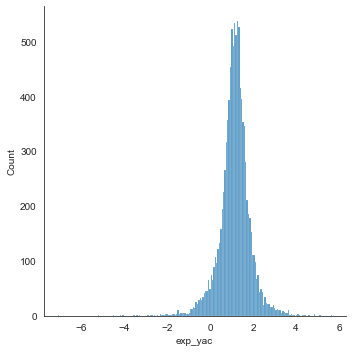

In [120]:
sns.displot(closest_yac_pred.exp_yac);

Finished [100%]: Average Loss = 33,879
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


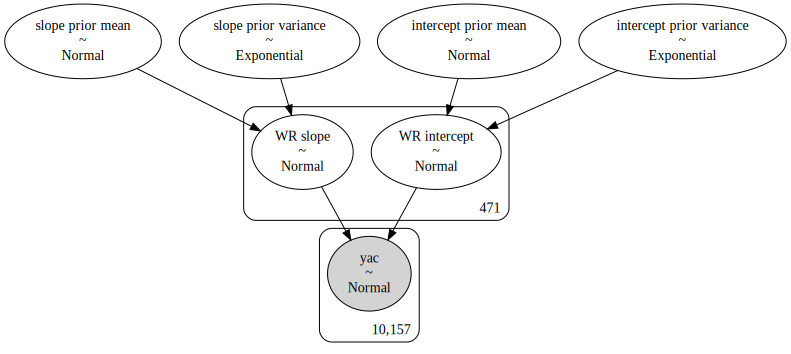

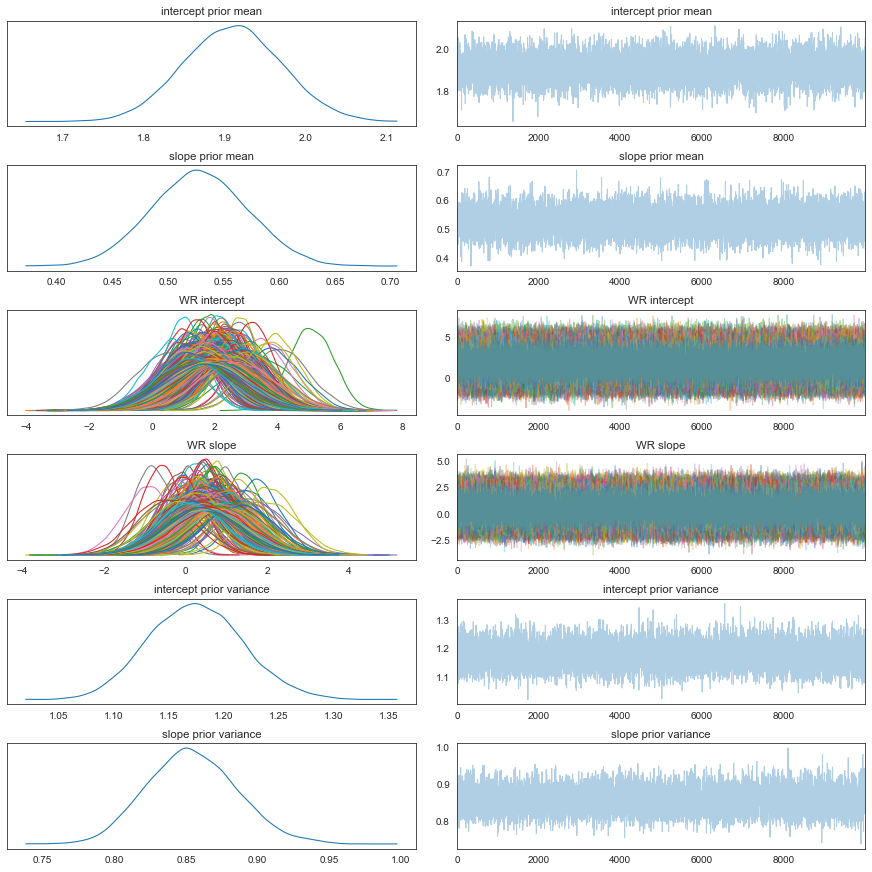

In [121]:
all_receivers = closest_yac_pred.off_nflId.unique() # nfl IDs of each unique WR
n_receivers = len(all_receivers) # number of unique WR
rec_lookup = dict(zip(all_receivers, range(n_receivers))) # WR lookup dictionary
rec = closest_yac_pred.off_nflId.replace(rec_lookup).values.astype(int) # get lookup values

true_yac = closest_yac_pred.true_yac.values # true outcome
pred_yac = closest_yac_pred.exp_yac.values # NN pred yac

with pm.Model() as yac_model:
    mu_a1 = pm.Normal('intercept prior mean', mu=0., sd=1e5) # normal intercept prior mean
    sigma_a1 = pm.Exponential('intercept prior variance', .5) # exponential intercept prior variance
    mu_b1 = pm.Normal('slope prior mean', mu=0., sd=1e5) # normal slope prior mean
    sigma_b1 = pm.Exponential('slope prior variance', .5) # exponential slope prior variance
    a1 = pm.Normal('WR intercept', mu=mu_a1, sd=sigma_a1, shape=n_receivers) # normal hierarchical intercept 
    b1 = pm.Normal('WR slope', mu=mu_b1, sd=sigma_b1, shape=n_receivers) # normal hierarchical slope
    mu1 = a1[rec] + b1[rec]*pred_yac # x1 = NN pred yac
#     yr1_adot = pm.Normal('hierarchical predicted next year aDOT', mu=mu1, sd=3.5, observed=adot1)
    yac = pm.Normal('yac', mu=mu1, sd=closest_yac_pred.true_yac.std(), observed=true_yac) 
    
#     comp_pct_trace = pm.sample(5000, tune=20000, init='adapt_diag', cores=4) # comp pct trace, 5k burn in / 20k sample
    yac_fit = pm.fit(40000, method='advi', random_seed=2)
    yac_trace = yac_fit.sample(10000)

pm.traceplot(yac_trace)

pm.model_to_graphviz(yac_model) 

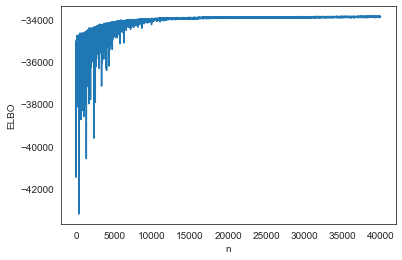

In [122]:
# check ELBO plot for convergence
advi_elbo = pd.DataFrame({'ELBO': -yac_fit.hist,
                          'n': np.arange(yac_fit.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [123]:
# obtain poterior predictions from sample / model
yac_posterior_pred = pm.sample_posterior_predictive(yac_trace, 10000, yac_model)
yac_posterior_pred

{'yac': array([[  4.0165584 ,   3.57438605,   7.78623234, ...,   9.86396506,
          -0.38607806,   0.47520561],
        [  2.68376986,  -0.04382809,  -5.01984935, ...,  -0.75457656,
           5.96275966,   0.16539705],
        [ -1.43901256,   3.46585876, -12.60653779, ...,   5.37270526,
         -11.05919001,  -4.05211917],
        ...,
        [  3.46618184, -10.07326945,  -3.35009625, ...,   3.89929672,
           4.16446665,  18.49619937],
        [ -1.82119765,   0.32662418,  -0.42903743, ...,   8.74207115,
          -5.24914815,  -2.92218383],
        [  3.78082469,  -1.98059708,   1.6146145 , ...,   3.61712963,
          18.86350834,  -1.49978554]])}

In [124]:
# average all 10k posterior preds for each play 
closest_yac_pred['posterior_yac_pred'] = yac_posterior_pred['yac'].mean(axis=0)

closest_yac_pred

,exp_yac,gameId,playId,true_yac,def_nflId,def_height,def_weight,def_birthDate,def_collegeName,def_position,def_displayName,offTeam,defTeam,off_nflId,off_position,off_displayName,posterior_yac_pred
0,1.369149,2018091601,3992,0.17,2560826.0,74,251,1996-12-28,Southern California,LB,Uchenna Nwosu,BUF,LAC,2552647.0,RB,Marcus Murphy,1.071176
1,1.116688,2018092307,2990,-0.36,2552312.0,72,232,1992-02-29,UCLA,MLB,Eric Kendricks,BUF,MIN,2552647.0,RB,Marcus Murphy,1.036217
2,1.486412,2018102103,1822,-3.00,2560789.0,74,230,1995-07-27,South Carolina State,LB,Darius Leonard,BUF,IND,2552647.0,RB,Marcus Murphy,0.939302
3,1.630543,2018102103,2263,-5.53,2560789.0,74,230,1995-07-27,South Carolina State,LB,Darius Leonard,BUF,IND,2552647.0,RB,Marcus Murphy,1.055604
4,0.567551,2018102103,3174,-3.94,238227.0,6-1,221,06/10/1987,Ohio U.,FS,Mike Mitchell,BUF,IND,2552647.0,RB,Marcus Murphy,0.925346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10152,0.261811,2018123013,1861,-1.18,2541958.0,70,195,1990-01-24,Central Michigan,SS,Jahleel Addae,DEN,LAC,2559485.0,WR,River Cracraft,1.901053
10153,1.662002,2018123002,3355,-1.01,2561527.0,72,198,1995-08-04,Southeast Missouri,CB,Mike Ford,GB,DET,2560787.0,WR,Allen Lazard,2.431405
10154,2.098869,2018123014,4088,1.73,2561006.0,72,208,1994-06-09,Florida,FS,Marcell Harris,LA,SF,2558875.0,TE,Johnny Mundt,2.723287
10155,0.527641,2018112500,3908,5.27,2552279.0,76,272,1992-09-08,Kentucky,OLB,Za'Darius Smith,OAK,BAL,2558950.0,WR,Keon Hatcher,2.104117


In [126]:
# get relevant columns for completion % analysis
yac_df = closest_yac_pred[['gameId', 'playId', 'def_nflId', 'defTeam', 'def_position', 
                   'off_nflId', 'offTeam', 'off_position', 'true_yac', 'exp_yac', 
                  'posterior_yac_pred', 'def_displayName', 'off_displayName']] 


In [138]:
# get play counts for DBs, find cutoff
over_twenty = yac_df[['def_nflId', 'gameId']].groupby(['def_nflId'], 
                                       as_index=False).aggregate('count').reset_index().sort_values('gameId', 
                                                                                                    ascending=False).query('gameId>30')



In [139]:
over_twenty # view data

,index,def_nflId,gameId
492,492,2560908.0,65
300,300,2555349.0,64
473,473,2560789.0,63
386,386,2558009.0,61
434,434,2558976.0,61
...,...,...,...
38,38,2495251.0,31
393,393,2558067.0,31
232,232,2552385.0,31
293,293,2555322.0,31


In [140]:
# subset to cutoff value using inner join
yac_df = pd.merge(yac_df, over_twenty[['def_nflId']], 
        how='inner', on='def_nflId')

# define yac under expectation
yac_df['yacue'] = yac_df.exp_yac - yac_df.true_yac

# define posterior yac under expectation
yac_df['yacue_post'] = yac_df.posterior_yac_pred - yac_df.true_yac 

# compute player expectation means
yacue_df = yac_df[['def_nflId', 'yacue']].groupby('def_nflId').aggregate('mean').reset_index().sort_values('yacue') 
yacue_post_df = yac_df[['def_nflId', 'yacue_post']].groupby('def_nflId').aggregate('mean').reset_index().sort_values('yacue_post')

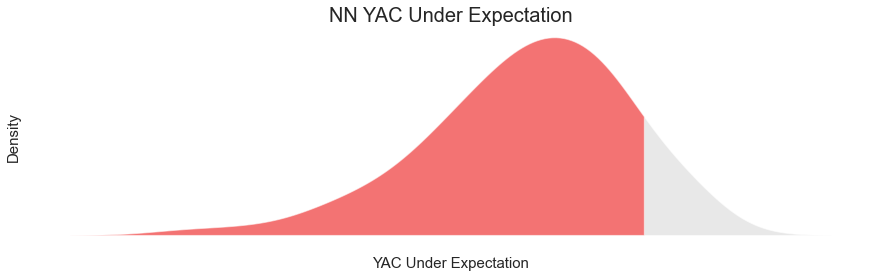

In [446]:
CUTOFF = 0

plt.figure(figsize=(15,4))
sns.set_style("white")
plt.box(on=None)
ax = sns.kdeplot(yacue_df.yacue)
ax.set(xticklabels=[], 
      yticklabels=[])
line = ax.get_lines()[-1]
x, y = line.get_data()
ax.get_lines()[0].remove()
ax.fill_between(x, y1=y, alpha=0.5, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
ax.set_title("NN YAC Under Expectation",fontsize=20)
ax.set_xlabel("YAC Under Expectation",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
ax.fill_between(x, y1=y, alpha=0.5, facecolor='red');

In [451]:
yacue_post_df.tail(15)

,def_nflId,yacue_post,nflId,height,weight,birthDate,collegeName,position,displayName
118,2539338.0,1.332020,2539338,71,190,1990-05-03,William & Mary,CB,B.W. Webb
119,2560952.0,1.334573,2560952,70,196,1997-02-09,Louisville,CB,Jaire Alexander
120,2557840.0,1.334609,2557840,72,202,1995-05-24,Colorado,CB,Chidobe Awuzie
121,2555530.0,1.410263,2555530,71,205,1994-12-12,Ohio State,FS,Vonn Bell
122,2552568.0,1.470476,2552568,72,205,1992-09-26,Connecticut,CB,Byron Jones
123,2540155.0,1.477996,2540155,73,218,1990-06-19,Florida State,CB,Xavier Rhodes
124,2558065.0,1.640819,2558065,71,185,1995-09-18,Southern California,CB,Adoree' Jackson
125,496733.0,1.669707,496733,71,195,1989-04-14,Florida,CB,Joe Haden
126,2540288.0,1.683760,2540288,72,190,1991-01-01,Mississippi State,CB,Darius Slay
127,2539334.0,1.830025,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant


In [156]:
# merge DB player info
yacue_post_df = pd.merge(yacue_post_df, players,
         how='inner', left_on='def_nflId', right_on='nflId')

yacue_post_df

,def_nflId,yacue_post,nflId,height,weight,birthDate,collegeName,position,displayName
0,2552312.0,-3.942168,2552312,72,232,1992-02-29,UCLA,MLB,Eric Kendricks
1,2560966.0,-3.333598,2560966,74,225,1996-12-25,Ohio State,LB,Jerome Baker
2,2552315.0,-3.112632,2552315,73,236,1992-06-27,Texas,MLB,Jordan Hicks
3,2560755.0,-2.671282,2560755,72,196,1996-04-03,Iowa,CB,Josh Jackson
4,2558136.0,-2.599251,2558136,72,204,1994-04-09,UCLA,CB,Fabian Moreau
...,...,...,...,...,...,...,...,...,...
128,2541162.0,1.880703,2541162,72,191,1991-08-16,Central Florida,CB,A.J. Bouye
129,2533062.0,1.888094,2533062,73,202,1990-09-19,South Carolina,CB,Stephon Gilmore
130,2552262.0,2.049592,2552262,69,197,1993-01-22,Texas,SS,Quandre Diggs
131,2558183.0,2.086700,2558183,72,209,1995-12-19,Boston College,SS,John Johnson


In [167]:
# merge w/ salary data
pd.merge(yacue_post_df, db_money,
        how='inner', left_on='displayName', right_on='Player') # .to_csv('yacue_post_df.csv', index=False)

,def_nflId,yacue_post,nflId,height,weight,birthDate,collegeName,position,displayName,Player,Team,pos,cap
0,2560755.0,-2.671282,2560755,72,196,1996-04-03,Iowa,CB,Josh Jackson,Josh Jackson,Packers,CB,1137473
1,2558136.0,-2.599251,2558136,72,204,1994-04-09,UCLA,CB,Fabian Moreau,Fabian Moreau,Washington,CB,794348
2,2543505.0,-2.141220,2543505,71,194,1992-05-01,Ohio State,CB,Bradley Roby,Bradley Roby,Broncos,CB,8526000
3,2553637.0,-1.935959,2553637,71,190,1993-03-27,Tennessee,CB,Justin Coleman,Justin Coleman,Seahawks,CB,2914000
4,2552434.0,-1.901738,2552434,71,192,1993-08-18,Memphis,CB,Bobby McCain,Bobby McCain,Dolphins,S,1502472
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2541162.0,1.880703,2541162,72,191,1991-08-16,Central Florida,CB,A.J. Bouye,A.J. Bouye,Jaguars,CB,15500000
83,2533062.0,1.888094,2533062,73,202,1990-09-19,South Carolina,CB,Stephon Gilmore,Stephon Gilmore,Patriots,CB,8887500
84,2552262.0,2.049592,2552262,69,197,1993-01-22,Texas,SS,Quandre Diggs,Quandre Diggs,Lions,S,2153838
85,2558183.0,2.086700,2558183,72,209,1995-12-19,Boston College,SS,John Johnson,John Johnson,Rams,S,772823


In [23]:
# yacue_post_df = pd.read_csv('yacue_post_df.csv')

In [79]:
cb_money = pd.read_csv('cb2018salaries.csv') # load CB salaries
cb_money['pos'] = 'CB' # define position

safety_money = pd.read_csv('safety2018salaries.csv') # load safety salaries
safety_money['pos'] = 'S' # define position

db_money = pd.concat([cb_money, safety_money], ignore_index=True) # stack dataframes 

# get cap # from string
db_money['cap'] = [int(''.join(map(str, c.strip('$').split(',')))) for c in list(db_money['Cap Number'])]

# subset to relevant columns
db_money = db_money[['Player', 'Team', 'pos', 'cap']]

db_money

,Player,Team,pos,cap
0,Josh Norman,Washington,CB,16937500
1,A.J. Bouye,Jaguars,CB,15500000
2,Patrick Peterson,Cardinals,CB,14956966
3,Xavier Rhodes,Vikings,CB,13400000
4,Jimmy Smith,Ravens,CB,13233040
...,...,...,...,...
471,Charlie Miller,Jets,S,15200
472,Jack Tocho,Washington,S,15200
473,Dean Marlowe,Bills,S,0
474,A.J. Hendy,Texans,S,0


In [197]:
# db_money.to_csv('db_money.csv')

In [28]:
tracking

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
0,2018-09-07T01:07:14.599Z,28.27,26.63,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN
1,2018-09-07T01:07:14.599Z,31.11,16.83,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN
2,2018-09-07T01:07:14.599Z,28.65,9.14,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH
3,2018-09-07T01:07:14.599Z,33.69,31.29,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN
4,2018-09-07T01:07:14.599Z,29.22,17.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15372937,2018-12-31T04:22:00.200Z,40.93,14.24,4.60,2.62,0.46,199.17,196.17,None,2558942.0,Anthony Firkser,86.0,TE,63,home,2018123011,4219,left,FLAT
15372938,2018-12-31T04:22:00.200Z,37.42,47.42,4.72,2.75,0.48,231.72,157.61,None,2558976.0,Kenny Moore,23.0,CB,63,away,2018123011,4219,left,NaN
15372939,2018-12-31T04:22:00.200Z,42.08,42.44,6.43,2.00,0.65,159.05,165.22,None,2560789.0,Darius Leonard,53.0,LB,63,away,2018123011,4219,left,NaN
15372940,2018-12-31T04:22:00.200Z,49.17,4.33,1.67,2.26,0.16,200.26,130.21,None,2561521.0,Cameron Batson,17.0,WR,63,home,2018123011,4219,left,OUT


# COVERAGE SONARS ("SHADOW SONAR")

#### DIRECTION OF MOVEMENT (NOT ORIENTATION) RELATIVE TO WR THEY'RE COVERING (PRIOR TO PASS FORWARD

#### FIELD VS. BOUNDARY (USE SNAP Y-AXIS LOCATION OF FOOTBALL)

In [35]:
# sort tracking data
tracking_sort = tracking.sort_values(['gameId', 'playId', 'frameId'], ascending=[True, True, True])

In [36]:
tracking_sort # view tracking data

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
0,2018-09-07T01:07:14.599Z,28.27,26.63,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN
1,2018-09-07T01:07:14.599Z,31.11,16.83,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN
2,2018-09-07T01:07:14.599Z,28.65,9.14,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH
3,2018-09-07T01:07:14.599Z,33.69,31.29,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN
4,2018-09-07T01:07:14.599Z,29.22,17.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15309141,2018-12-31T00:23:40.700Z,51.68,39.70,2.24,0.98,0.22,149.35,144.92,None,2553439.0,Mike Davis,27.0,RB,80,home,2018123015,4104,right,FLAT
15309142,2018-12-31T00:23:40.700Z,55.11,44.26,0.81,0.49,0.08,145.62,158.36,None,2557887.0,Haason Reddick,43.0,ILB,80,away,2018123015,4104,right,NaN
15309143,2018-12-31T00:23:40.700Z,44.69,28.61,3.89,0.74,0.39,83.28,91.09,None,2558009.0,Budda Baker,36.0,FS,80,away,2018123015,4104,right,NaN
15309144,2018-12-31T00:23:40.700Z,64.16,21.43,3.55,1.35,0.36,176.15,170.95,None,2558856.0,David Moore,83.0,WR,80,home,2018123015,4104,right,IN


In [37]:
# find location of football at the start of every play
football_start = tracking_sort.query('team=="football"').query('frameId==1')[['gameId', 'playId', 'y']]

# rename columns
football_start.columns = ['gameId', 'playId', 'football_y']

football_start.head()

,gameId,playId,football_y
13,2018090600,75,26.45
839,2018090600,146,23.44
1525,2018090600,168,23.50
2197,2018090600,190,23.55
3217,2018090600,256,29.33


In [38]:
# merge football starting location w/ tracking data
all_start = pd.merge(football_start, tracking_sort.query('team!="football"').query('frameId==1'),
        how='inner', on=['playId', 'gameId'])

all_start

,gameId,playId,football_y,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,playDirection,route
0,2018090600,75,26.45,2018-09-07T01:07:14.599Z,28.27,26.63,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,left,NaN
1,2018090600,75,26.45,2018-09-07T01:07:14.599Z,31.11,16.83,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,left,NaN
2,2018090600,75,26.45,2018-09-07T01:07:14.599Z,28.65,9.14,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,left,HITCH
3,2018090600,75,26.45,2018-09-07T01:07:14.599Z,33.69,31.29,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,left,NaN
4,2018090600,75,26.45,2018-09-07T01:07:14.599Z,29.22,17.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,left,HITCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223337,2018123015,4104,29.87,2018-12-31T00:23:32.799Z,46.56,10.96,0.00,0.01,0.00,81.53,104.32,None,2552430.0,Tyler Lockett,16.0,WR,1,home,right,GO
223338,2018123015,4104,29.87,2018-12-31T00:23:32.799Z,42.60,32.92,0.03,0.03,0.01,87.01,261.32,None,2553439.0,Mike Davis,27.0,RB,1,home,right,FLAT
223339,2018123015,4104,29.87,2018-12-31T00:23:32.799Z,50.94,32.56,0.08,1.01,0.01,254.25,209.64,None,2557887.0,Haason Reddick,43.0,ILB,1,away,right,NaN
223340,2018123015,4104,29.87,2018-12-31T00:23:32.799Z,49.08,22.00,1.88,3.25,0.19,269.82,206.62,None,2558009.0,Budda Baker,36.0,FS,1,away,right,NaN


In [39]:
# is the boundary side on the right
all_start['rightIsB'] = np.where(all_start['football_y']<26.65, 1, 0) 

# is the player on the right of the ball
all_start['playerRight'] = np.where(all_start['y']<all_start['football_y'], 1, 0) 

# is player on the "field" side of the ball for this play
all_start['sideField'] = np.where((all_start['rightIsB']+all_start['playerRight'])==1, 1, 0) 

all_start[['gameId', 'playId', 'nflId', 'sideField', 'rightIsB']]

,gameId,playId,nflId,sideField,rightIsB
0,2018090600,75,310.0,1,1
1,2018090600,75,79848.0,0,1
2,2018090600,75,2495454.0,0,1
3,2018090600,75,2495613.0,1,1
4,2018090600,75,2533040.0,0,1
...,...,...,...,...,...
223337,2018123015,4104,2552430.0,1,0
223338,2018123015,4104,2553439.0,0,0
223339,2018123015,4104,2557887.0,0,0
223340,2018123015,4104,2558009.0,1,0


In [40]:
# unique tracking player positions
tracking_sort.position.unique()

array(['QB', 'SS', 'WR', 'FS', 'RB', 'MLB', 'CB', 'TE', 'LB', 'FB', nan,
       'OLB', 'ILB', 'DB', 'DL', 'HB', 'NT', 'S', 'DE', 'DT'],
      dtype=object)

In [41]:
# subset to DBs
tracking_db = tracking_sort[tracking_sort['position'].isin(['SS', 'FS', 'CB', 'DB', 'S'])]

# subset to DBs w/ salary data
tracking_db = tracking_db[tracking_db['displayName'].isin(list(db_money.Player))]

tracking_db

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
1,2018-09-07T01:07:14.599Z,31.11,16.83,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN
3,2018-09-07T01:07:14.599Z,33.69,31.29,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN
5,2018-09-07T01:07:14.599Z,46.36,24.60,0.03,0.02,0.01,103.05,219.41,None,2534832.0,Rodney McLeod,23.0,FS,1,home,2018090600,75,left,NaN
8,2018-09-07T01:07:14.599Z,37.33,32.77,0.03,0.07,0.01,81.14,174.57,None,2552689.0,Ronald Darby,21.0,CB,1,home,2018090600,75,left,NaN
9,2018-09-07T01:07:14.599Z,36.00,9.81,0.14,0.05,0.01,108.23,110.32,None,2555383.0,Jalen Mills,31.0,CB,1,home,2018090600,75,left,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15309133,2018-12-31T00:23:40.700Z,65.69,23.95,1.12,1.69,0.12,105.02,151.11,None,2495504.0,Patrick Peterson,21.0,CB,80,away,2018123015,4104,right,NaN
15309134,2018-12-31T00:23:40.700Z,82.08,2.56,4.90,3.47,0.51,87.06,119.64,None,2495807.0,Antoine Bethea,41.0,FS,80,away,2018123015,4104,right,NaN
15309137,2018-12-31T00:23:40.700Z,72.51,0.84,2.76,2.19,0.28,54.32,130.24,None,2540170.0,David Amerson,38.0,CB,80,away,2018123015,4104,right,NaN
15309139,2018-12-31T00:23:40.700Z,85.34,0.20,7.83,3.05,0.80,164.47,160.15,None,2543830.0,Tre Boston,33.0,FS,80,away,2018123015,4104,right,NaN


In [42]:
# subset to route runners
tracking_wr = tracking_sort[tracking_sort.route.notnull()]

tracking_wr

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
2,2018-09-07T01:07:14.599Z,28.65,9.14,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH
4,2018-09-07T01:07:14.599Z,29.22,17.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH
10,2018-09-07T01:07:14.599Z,28.71,31.47,0.01,0.02,0.01,250.34,151.83,None,2555415.0,Austin Hooper,81.0,TE,1,away,2018090600,75,left,OUT
12,2018-09-07T01:07:14.599Z,24.87,26.59,0.01,0.01,0.01,250.10,237.27,None,2559033.0,Ricky Ortiz,30.0,FB,1,away,2018090600,75,left,FLAT
16,2018-09-07T01:07:14.700Z,28.63,9.13,0.03,0.03,0.02,290.45,29.61,None,2495454.0,Julio Jones,11.0,WR,2,away,2018090600,75,left,HITCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15309130,2018-12-31T00:23:40.599Z,64.10,21.79,3.68,1.28,0.37,170.86,171.58,out_of_bounds,2558856.0,David Moore,83.0,WR,79,home,2018123015,4104,right,IN
15309135,2018-12-31T00:23:40.700Z,66.46,10.63,0.13,0.24,0.01,168.09,279.07,None,2530747.0,Doug Baldwin,89.0,WR,80,home,2018123015,4104,right,CORNER
15309140,2018-12-31T00:23:40.700Z,85.46,-0.92,7.15,2.13,0.71,101.22,135.45,None,2552430.0,Tyler Lockett,16.0,WR,80,home,2018123015,4104,right,GO
15309141,2018-12-31T00:23:40.700Z,51.68,39.70,2.24,0.98,0.22,149.35,144.92,None,2553439.0,Mike Davis,27.0,RB,80,home,2018123015,4104,right,FLAT


In [43]:
# find frameId for pass forward
find_pass_forward = tracking_wr.query('event=="pass_forward"')[['gameId', 'playId', 'frameId']].drop_duplicates()

# rename columns
find_pass_forward.columns = ['gameId', 'playId', 'frame_pass_forward']

# subset WR tracking to <= pass forward frame
tracking_wr = pd.merge(tracking_wr, find_pass_forward,
        how='inner', on=['playId', 'gameId']).query('frameId<=frame_pass_forward')

# subset DB tracking to <= pass forward frame
tracking_db = pd.merge(tracking_db, find_pass_forward,
                      how='inner', on=['playId', 'gameId']).query('frameId<=frame_pass_forward')

In [44]:
tracking_db.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,frame_pass_forward
0,2018-09-07T01:07:14.599Z,31.11,16.83,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN,36
1,2018-09-07T01:07:14.599Z,33.69,31.29,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN,36
2,2018-09-07T01:07:14.599Z,46.36,24.60,0.03,0.02,0.01,103.05,219.41,None,2534832.0,Rodney McLeod,23.0,FS,1,home,2018090600,75,left,NaN,36
3,2018-09-07T01:07:14.599Z,37.33,32.77,0.03,0.07,0.01,81.14,174.57,None,2552689.0,Ronald Darby,21.0,CB,1,home,2018090600,75,left,NaN,36
4,2018-09-07T01:07:14.599Z,36.00,9.81,0.14,0.05,0.01,108.23,110.32,None,2555383.0,Jalen Mills,31.0,CB,1,home,2018090600,75,left,NaN,36


In [45]:
tracking_wr.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,frame_pass_forward
0,2018-09-07T01:07:14.599Z,28.65,9.14,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,36
1,2018-09-07T01:07:14.599Z,29.22,17.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,36
2,2018-09-07T01:07:14.599Z,28.71,31.47,0.01,0.02,0.01,250.34,151.83,None,2555415.0,Austin Hooper,81.0,TE,1,away,2018090600,75,left,OUT,36
3,2018-09-07T01:07:14.599Z,24.87,26.59,0.01,0.01,0.01,250.10,237.27,None,2559033.0,Ricky Ortiz,30.0,FB,1,away,2018090600,75,left,FLAT,36
4,2018-09-07T01:07:14.700Z,28.63,9.13,0.03,0.03,0.02,290.45,29.61,None,2495454.0,Julio Jones,11.0,WR,2,away,2018090600,75,left,HITCH,36


In [46]:
tracking_db = tracking_db[['gameId', 'playId', 'frameId', 'x', 'y', 's', 'dir', 'nflId']]
tracking_wr = tracking_wr[['gameId', 'playId', 'frameId', 'x', 'y', 's', 'dir', 'nflId']]
tracking_db.columns = ['gameId', 'playId', 'frameId', 'db_x', 'db_y', 'db_s', 'db_dir', 'db_nflId']
tracking_wr.columns = ['gameId', 'playId', 'frameId', 'wr_x', 'wr_y', 'wr_s', 'wr_dir', 'wr_nflId']

trackingDbWr = pd.merge(tracking_db, tracking_wr, 
                       how='inner', on=['gameId', 'playId', 'frameId'])

trackingDbWr = pd.merge(trackingDbWr, targets,
                       how='inner', 
                        left_on=['gameId', 'playId', 'wr_nflId'],
                       right_on=['gameId', 'playId', 'targetNflId']) 

In [47]:
pd.options.mode.chained_assignment = None  # default='warn'

In [136]:
%%time 
# get unqiue play and game Ids to loop through
coverage_pg = trackingDbWr[['playId', 'gameId']].drop_duplicates() 

# initialize final df
coverage_df = pd.DataFrame()

# number of plays in set
n_total = coverage_pg.shape[0]

# deciles
n9 = list(np.round(np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1])*n_total))

# starter
n_now = 0 

for i in range(n_total):
    if i+1 in n9:
        n_now += 1
        print(str(n_now)+'0% DONE')
    pg = coverage_pg.iloc[i,] # subset to row of play/game df
    play_i = pg['playId'] # get play ID
    game_i = pg['gameId'] # get game ID 
    # get WR/DB tracking data for each play
    tracking_pg = trackingDbWr[(trackingDbWr['playId']==play_i) & (trackingDbWr['gameId']==game_i)]

    # calculate WR/DB distance 
    tracking_pg['wr_db_dist'] = np.vectorize(dist)(tracking_pg['wr_x'], tracking_pg['wr_y'], 
                                                   tracking_pg['db_x'], tracking_pg['db_y'])
    # subset to closest @ each frame
    calc_closest = pd.merge(tracking_pg, 
                            tracking_pg[['gameId', 'playId', 'frameId', 'wr_nflId', 
                                         'wr_db_dist']].groupby(['gameId', 'playId', 'frameId', 
                                                                 'wr_nflId']).agg('min').reset_index(),
                            how='inner', on=['gameId', 'playId', 'frameId', 'wr_nflId', 'wr_db_dist'])
    coverage_df = pd.concat([coverage_df, calc_closest], ignore_index=True) # concat w/ full df


10% DONE
20% DONE
30% DONE
40% DONE
50% DONE
60% DONE
70% DONE
80% DONE
90% DONE
100% DONE
CPU times: user 8min 45s, sys: 3min 14s, total: 12min
Wall time: 10min 31s


In [137]:
# % of play each DB covers each WR's route for (closest) 
coverage_pct = pd.DataFrame(coverage_df[['gameId', 'playId', 'wr_nflId', 
                          'db_nflId']].groupby(['gameId', 'playId', 
                                                'wr_nflId'])['db_nflId'].value_counts(
    normalize=True)).rename_axis(
    ['gameId', 'playId', 'wrId', 'dbId']).reset_index() 

In [138]:
man_coverage = coverage_pct.query('db_nflId==1.0') # full coverage

man_coverage

,gameId,playId,wrId,dbId,db_nflId
0,2018090600,75,2495454.0,2555383.0,1.0
1,2018090600,146,2560854.0,79848.0,1.0
6,2018090600,256,2543583.0,79848.0,1.0
18,2018090600,636,2555415.0,2552689.0,1.0
19,2018090600,752,2552600.0,2539653.0,1.0
...,...,...,...,...,...
22866,2018123015,2998,2558208.0,2534846.0,1.0
22869,2018123015,3180,2555289.0,2495504.0,1.0
22878,2018123015,3794,2561272.0,2560728.0,1.0
22879,2018123015,3819,2558208.0,2560728.0,1.0


In [139]:
both_cov = pd.merge(trackingDbWr, man_coverage[['gameId', 'playId', 'wrId', 'dbId']],
         how='inner', 
         left_on=['gameId', 'playId', 'wr_nflId', 'db_nflId'],
        right_on=['gameId', 'playId', 'wrId', 'dbId'])

In [140]:
both_cov

,gameId,playId,frameId,db_x,db_y,db_s,db_dir,db_nflId,wr_x,wr_y,wr_s,wr_dir,wr_nflId,targetNflId,wrId,dbId
0,2018090600,75,1,36.00,9.81,0.14,110.32,2555383.0,28.65,9.14,0.02,16.86,2495454.0,2495454.0,2495454.0,2555383.0
1,2018090600,75,2,35.98,9.81,0.14,106.73,2555383.0,28.63,9.13,0.03,29.61,2495454.0,2495454.0,2495454.0,2555383.0
2,2018090600,75,3,35.97,9.81,0.13,107.41,2555383.0,28.63,9.13,0.02,32.20,2495454.0,2495454.0,2495454.0,2555383.0
3,2018090600,75,4,35.97,9.82,0.11,107.14,2555383.0,28.63,9.13,0.02,34.52,2495454.0,2495454.0,2495454.0,2555383.0
4,2018090600,75,5,35.98,9.82,0.08,112.28,2555383.0,28.63,9.14,0.02,38.72,2495454.0,2495454.0,2495454.0,2555383.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343067,2018123015,4057,33,47.29,32.69,3.21,67.83,2558009.0,37.48,30.39,5.76,34.29,2553439.0,2553439.0,2553439.0,2558009.0
343068,2018123015,4057,34,47.58,32.85,3.31,56.92,2558009.0,37.79,30.90,6.00,30.75,2553439.0,2553439.0,2553439.0,2558009.0
343069,2018123015,4057,35,47.84,33.07,3.49,47.80,2558009.0,38.09,31.43,6.17,27.72,2553439.0,2553439.0,2553439.0,2558009.0
343070,2018123015,4057,36,48.09,33.35,3.77,39.33,2558009.0,38.36,31.99,6.29,25.07,2553439.0,2553439.0,2553439.0,2558009.0


In [98]:
# # cut out burn in to play (0.5 seconds)
# wr_coverage = tracking_wr.query('frameId>5')
# db_coverage = tracking_db.query('frameId>5')[['x', 'y', 'dir', 'nflId', 'gameId', 'playId', 'frameId']]

# # rename columns
# wr_coverage.columns = ['wr_x', 'wr_y', 'wrId', 'gameId', 'playId', 'frameId']
# db_coverage.columns = ['db_x', 'db_y', 'db_dir', 'dbId', 'gameId', 'playId', 'frameId']

In [99]:

# both_cov = pd.merge(pd.merge(wr_coverage, man_coverage[['gameId', 'playId', 'wrId', 'dbId']],
#          how='inner', on=['gameId', 'playId', 'wrId']), db_coverage,
#          how='inner', on=['gameId', 'playId', 'frameId', 'dbId'])

# both_cov

In [48]:
# both_cov.to_csv('wr_db_both_targeted.csv', index=False) 
both_cov = pd.read_csv('wr_db_both_targeted.csv').query("frameId>5") 

In [49]:
# α = arccos[(xa * xb + ya * yb) / (√(xa2 + ya2) * √(xb2 + yb2))]

both_coverage = pd.merge(both_cov, all_start[['gameId', 'playId', 'nflId', 'sideField', 'rightIsB']],
         how='inner', left_on=['gameId', 'playId', 'dbId'], right_on=['gameId', 'playId', 'nflId']).drop_duplicates()

both_coverage

,gameId,playId,frameId,db_x,db_y,db_s,db_dir,db_nflId,wr_x,wr_y,wr_s,wr_dir,wr_nflId,targetNflId,wrId,dbId,nflId,sideField,rightIsB
0,2018090600,75,6,35.99,9.82,0.05,123.91,2555383.0,28.62,9.14,0.01,46.06,2495454.0,2495454.0,2495454.0,2555383.0,2555383.0,0,1
1,2018090600,75,7,36.00,9.82,0.03,139.99,2555383.0,28.62,9.15,0.01,51.57,2495454.0,2495454.0,2495454.0,2555383.0,2555383.0,0,1
2,2018090600,75,8,36.04,9.84,0.04,217.47,2555383.0,28.62,9.15,0.01,58.15,2495454.0,2495454.0,2495454.0,2555383.0,2555383.0,0,1
3,2018090600,75,9,36.05,9.85,0.06,221.62,2555383.0,28.62,9.16,0.01,62.78,2495454.0,2495454.0,2495454.0,2555383.0,2555383.0,0,1
4,2018090600,75,10,36.07,9.85,0.06,229.18,2555383.0,28.62,9.16,0.01,63.87,2495454.0,2495454.0,2495454.0,2555383.0,2555383.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295847,2018123015,4057,33,47.29,32.69,3.21,67.83,2558009.0,37.48,30.39,5.76,34.29,2553439.0,2553439.0,2553439.0,2558009.0,2558009.0,1,1
295848,2018123015,4057,34,47.58,32.85,3.31,56.92,2558009.0,37.79,30.90,6.00,30.75,2553439.0,2553439.0,2553439.0,2558009.0,2558009.0,1,1
295849,2018123015,4057,35,47.84,33.07,3.49,47.80,2558009.0,38.09,31.43,6.17,27.72,2553439.0,2553439.0,2553439.0,2558009.0,2558009.0,1,1
295850,2018123015,4057,36,48.09,33.35,3.77,39.33,2558009.0,38.36,31.99,6.29,25.07,2553439.0,2553439.0,2553439.0,2558009.0,2558009.0,1,1


In [50]:
both_coverage = pd.merge(both_coverage, football_start,
        how='inner', on=['playId', 'gameId'])

both_coverage

,gameId,playId,frameId,db_x,db_y,db_s,db_dir,db_nflId,wr_x,wr_y,wr_s,wr_dir,wr_nflId,targetNflId,wrId,dbId,nflId,sideField,rightIsB,football_y
0,2018090600,75,6,35.99,9.82,0.05,123.91,2555383.0,28.62,9.14,0.01,46.06,2495454.0,2495454.0,2495454.0,2555383.0,2555383.0,0,1,26.45
1,2018090600,75,7,36.00,9.82,0.03,139.99,2555383.0,28.62,9.15,0.01,51.57,2495454.0,2495454.0,2495454.0,2555383.0,2555383.0,0,1,26.45
2,2018090600,75,8,36.04,9.84,0.04,217.47,2555383.0,28.62,9.15,0.01,58.15,2495454.0,2495454.0,2495454.0,2555383.0,2555383.0,0,1,26.45
3,2018090600,75,9,36.05,9.85,0.06,221.62,2555383.0,28.62,9.16,0.01,62.78,2495454.0,2495454.0,2495454.0,2555383.0,2555383.0,0,1,26.45
4,2018090600,75,10,36.07,9.85,0.06,229.18,2555383.0,28.62,9.16,0.01,63.87,2495454.0,2495454.0,2495454.0,2555383.0,2555383.0,0,1,26.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295539,2018123015,4057,33,47.29,32.69,3.21,67.83,2558009.0,37.48,30.39,5.76,34.29,2553439.0,2553439.0,2553439.0,2558009.0,2558009.0,1,1,23.84
295540,2018123015,4057,34,47.58,32.85,3.31,56.92,2558009.0,37.79,30.90,6.00,30.75,2553439.0,2553439.0,2553439.0,2558009.0,2558009.0,1,1,23.84
295541,2018123015,4057,35,47.84,33.07,3.49,47.80,2558009.0,38.09,31.43,6.17,27.72,2553439.0,2553439.0,2553439.0,2558009.0,2558009.0,1,1,23.84
295542,2018123015,4057,36,48.09,33.35,3.77,39.33,2558009.0,38.36,31.99,6.29,25.07,2553439.0,2553439.0,2553439.0,2558009.0,2558009.0,1,1,23.84


In [51]:
both_coverage['wr_y'] = np.where(both_coverage['rightIsB']==1,
                                both_coverage['wr_y'],
                                53.3-both_coverage['wr_y'])

both_coverage['db_y'] = np.where(both_coverage['rightIsB']==1,
                                both_coverage['db_y'],
                                53.3-both_coverage['db_y'])

In [52]:
# get angle b/t DB direction and endpoint of WR velocity VECTOR 
both_coverage['wr_angle'] = np.vectorize(get_angle)(both_coverage['db_x'], both_coverage['db_y'], 
                                                    both_coverage['db_x'], both_coverage['db_y']+60,
                                                   both_coverage['db_x'], both_coverage['db_y'],
                                                   both_coverage['wr_x'] + (both_coverage['wr_s'] * np.sin(np.deg2rad(both_coverage['wr_dir']))), 
                                                    both_coverage['wr_y'] + (both_coverage['wr_s'] * np.cos(np.deg2rad(both_coverage['wr_dir']))))

both_coverage['wr_angle'] = np.where(both_coverage['db_x']>both_coverage['wr_x'], 
                                     360-both_coverage['wr_angle'],
                                    both_coverage['wr_angle'])

both_coverage['rotate'] = np.where(both_coverage['wr_angle']>180, 
                                   360-both_coverage['wr_angle'],
                                  -1*both_coverage['wr_angle'])

both_coverage['diff_angle'] = np.where((both_coverage['db_dir']+both_coverage['rotate'])>180,
                                      (both_coverage['db_dir']+both_coverage['rotate'])-360,
                                      both_coverage['db_dir']+both_coverage['rotate'])

both_coverage['diff_angleR'] = np.deg2rad(both_coverage.diff_angle)

both_coverage

,gameId,playId,frameId,db_x,db_y,db_s,db_dir,db_nflId,wr_x,wr_y,...,wrId,dbId,nflId,sideField,rightIsB,football_y,wr_angle,rotate,diff_angle,diff_angleR
0,2018090600,75,6,35.99,9.82,0.05,123.91,2555383.0,28.62,9.14,...,2495454.0,2555383.0,2555383.0,0,1,26.45,264.776896,95.223104,-140.866896,-2.458591
1,2018090600,75,7,36.00,9.82,0.03,139.99,2555383.0,28.62,9.15,...,2495454.0,2555383.0,2555383.0,0,1,26.45,264.855004,95.144996,-124.865004,-2.179305
2,2018090600,75,8,36.04,9.84,0.04,217.47,2555383.0,28.62,9.15,...,2495454.0,2555383.0,2555383.0,0,1,26.45,264.721627,95.278373,-47.251627,-0.824696
3,2018090600,75,9,36.05,9.85,0.06,221.62,2555383.0,28.62,9.16,...,2495454.0,2555383.0,2555383.0,0,1,26.45,264.723037,95.276963,-43.103037,-0.752290
4,2018090600,75,10,36.07,9.85,0.06,229.18,2555383.0,28.62,9.16,...,2495454.0,2555383.0,2555383.0,0,1,26.45,264.735783,95.264217,-35.555783,-0.620565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295539,2018123015,4057,33,47.29,32.69,3.21,67.83,2558009.0,37.48,30.39,...,2553439.0,2558009.0,2558009.0,1,1,23.84,290.533450,69.466550,137.296550,2.396277
295540,2018123015,4057,34,47.58,32.85,3.31,56.92,2558009.0,37.79,30.90,...,2553439.0,2558009.0,2558009.0,1,1,23.84,295.500651,64.499349,121.419349,2.119167
295541,2018123015,4057,35,47.84,33.07,3.49,47.80,2558009.0,38.09,31.43,...,2553439.0,2558009.0,2558009.0,1,1,23.84,299.052345,60.947655,108.747655,1.898005
295542,2018123015,4057,36,48.09,33.35,3.77,39.33,2558009.0,38.36,31.99,...,2553439.0,2558009.0,2558009.0,1,1,23.84,301.547900,58.452100,97.782100,1.706620


In [53]:
field_coverage = both_coverage.query('sideField==1')
boundary_coverage = both_coverage.query('sideField==0')

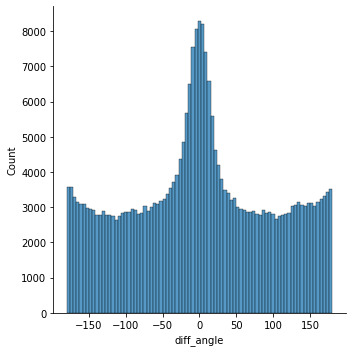

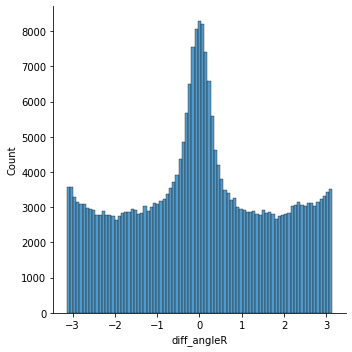

In [54]:
sns.displot(both_coverage.diff_angle), sns.displot(both_coverage.diff_angleR);

In [55]:
j_id = players[players['displayName']==NAME].iloc[0,]['nflId']

NameError: name 'NAME' is not defined

In [56]:
vm_field_all = vonmises_kde(field_coverage.diff_angleR, 1)
vm_boundary_all = vonmises_kde(boundary_coverage.diff_angleR, 1)
vm_field_alexander = vonmises_kde(field_coverage[field_coverage['dbId']==j_id].diff_angleR, 1)
vm_boundary_alexander = vonmises_kde(boundary_coverage[boundary_coverage['dbId']==j_id].diff_angleR, 1)

/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


NameError: name 'j_id' is not defined

/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


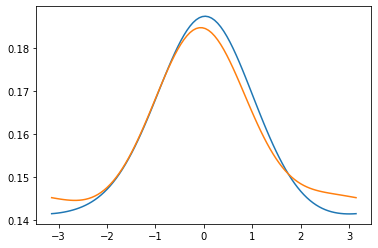

In [57]:
sns.lineplot(vm_field_all[0], vm_field_all[1]), sns.lineplot(vm_boundary_all[0], vm_boundary_all[1]);

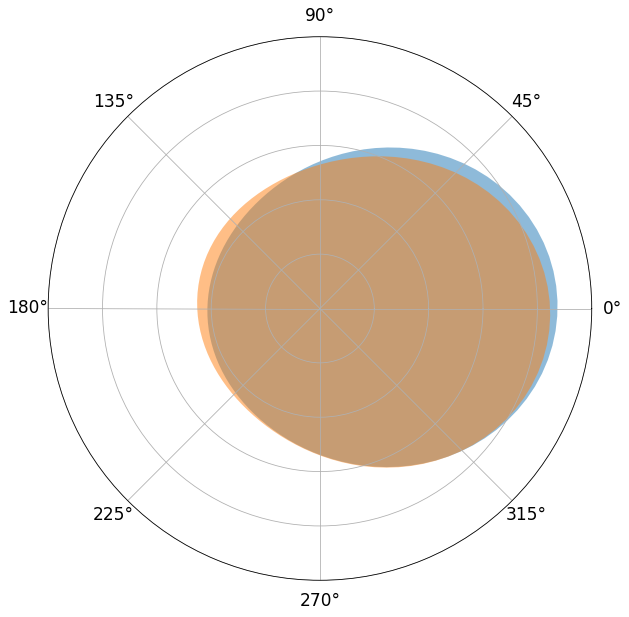

In [58]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)
ax.set(ylim=(0.1, # float(np.min(vm_field_all[1])) - .02, 
             .2), # round(float(np.max(vm_field_all[1])),3) + .05),
      yticklabels=[])
ax.tick_params(labelsize=17, pad=10)
ax.plot(vm_field_all[0], vm_field_all[1], color="none")
ax.fill_between(vm_field_all[0], vm_field_all[1], alpha=0.5)
ax.plot(vm_boundary_all[0], vm_boundary_all[1], color="none")
ax.fill_between(vm_boundary_all[0], vm_boundary_all[1], alpha=0.5)
plt.savefig('all_cov.png', dpi=600);

In [60]:
gmm_data[['yacue_post', 'cpue', 'tarue', 'sepue', 'age', 'Player', 'cap', 'exp_cap', 'capue', 'pos']].sort_values('capue', 
                                                                                                       ascending=False).round(2).head(20)

,yacue_post,cpue,tarue,sepue,age,Player,cap,exp_cap,capue,pos
58,1.02,-0.02,-0.03,-0.01,26,Briean Boddy-Calhoun,630000,5981839.87,5351839.87,S
48,0.45,0.02,-0.04,-0.33,24,Mike Hilton,555000,5885289.40,5330289.40,CB
68,1.33,0.04,-0.05,0.47,23,Chidobe Awuzie,973541,5982227.89,5008686.89,CB
78,2.34,0.16,-0.02,-0.43,25,Ronald Darby,1058139,5982308.22,4924169.22,CB
23,-0.37,0.03,0.02,0.77,23,Tre Flowers,554681,5329799.32,4775118.32,CB
66,1.33,0.08,0.02,0.52,28,B.W. Webb,655000,5337663.15,4682663.15,CB
52,0.67,0.01,0.04,0.85,23,Shaquill Griffin,777655,5336292.85,4558637.85,CB
69,1.41,-0.07,0.01,1.04,24,Vonn Bell,1083354,5345129.27,4261775.27,S
18,-0.76,0.04,-0.04,-0.13,31,Shareece Wright,592941,4545769.74,3952828.74,CB
67,1.33,0.06,-0.01,0.57,22,Jaire Alexander,2191042,5968455.28,3777413.28,CB


/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


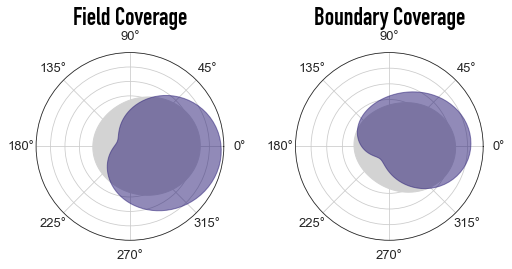

In [110]:
t_col = '#241773'
p_col = '#000000'
NAME = "Marcus Peters"

padding_i = 5

j_id = players[players['displayName']==NAME].iloc[0,]['nflId']
vm_field_alexander = vonmises_kde(field_coverage[field_coverage['dbId']==j_id].diff_angleR, 1)
vm_boundary_alexander = vonmises_kde(boundary_coverage[boundary_coverage['dbId']==j_id].diff_angleR, 1)

plt.figure(figsize=(8,8))
ax = plt.subplot(1,2,1, polar=True)
ax.set(ylim=(.09, # float(np.min(vm_field_all[1])) - .013, 
             .22), # round(float(np.max(vm_field_alexander[1])),2) + .05),
#       xticklabels=[], 
      yticklabels=[])
ax.tick_params(labelsize=13, pad=padding_i)
ax.set_title('Field Coverage',
            font='DIN Condensed', fontsize=25, color=p_col)
ax.plot(vm_field_all[0], vm_field_all[1], color='none')
ax.fill_between(vm_field_all[0], vm_field_all[1], alpha=1, color='lightgray')
ax.plot(vm_field_alexander[0], vm_field_alexander[1], color='none')
ax.fill_between(vm_field_alexander[0], vm_field_alexander[1], alpha=0.5, color=t_col)
plt.tight_layout(pad=5.0)
# plt.figure(figsize=(8,8))
ax = plt.subplot(1,2,2, polar=True)
ax.set(ylim=(.1, # float(np.min(vm_boundary_all[1])) - .005, 
             .22), # round(float(np.max(vm_boundary_alexander[1])),2) + .05),
#       xticklabels=[], 
      yticklabels=[])
ax.tick_params(labelsize=13, pad=padding_i)
ax.set_title('Boundary Coverage',
            font='DIN Condensed', fontsize=25, color=p_col)
ax.plot(vm_boundary_all[0], vm_boundary_all[1], color='none')
ax.fill_between(vm_boundary_all[0], vm_boundary_all[1], alpha=1, color='lightgray')
ax.plot(vm_boundary_alexander[0], vm_boundary_alexander[1], color='none')
ax.fill_between(vm_boundary_alexander[0], vm_boundary_alexander[1], alpha=0.5, color=t_col)
plt.savefig('peters.png', dpi=600);
# plt.suptitle(NAME, font='DIN Condensed', size=35,
#             y=.81);
# fig.subplots_adjust(top=10)
# fig.show()

/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/Users/alexcstern/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


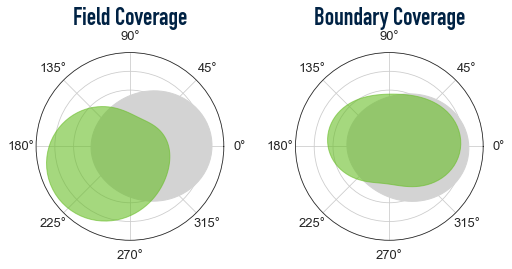

In [112]:
p_col = '#69be28'
t_col = '#002244'

NAME = "Shaquill Griffin"

padding_i = 5

s_id = players[players['displayName']==NAME].iloc[0,]['nflId']
vm_field_griffin = vonmises_kde(field_coverage[field_coverage['dbId']==s_id].diff_angleR, 1)
vm_boundary_griffin = vonmises_kde(boundary_coverage[boundary_coverage['dbId']==s_id].diff_angleR, 1)

plt.figure(figsize=(8,8))
ax = plt.subplot(1,2,1, polar=True)
ax.set(ylim=(.1, # float(np.min(vm_field_all[1])) - .01, 
             .2), # round(float(np.max(vm_field_griffin[1])),2) + .05),
#       xticklabels=[], 
      yticklabels=[])
ax.tick_params(labelsize=13, pad=padding_i)
ax.set_title('Field Coverage',
            font='DIN Condensed', fontsize=25, color=t_col)
ax.plot(vm_field_all[0], vm_field_all[1], color='none')
ax.fill_between(vm_field_all[0], vm_field_all[1], alpha=1, color='lightgray')
ax.plot(vm_field_griffin[0], vm_field_griffin[1], color='none')
ax.fill_between(vm_field_griffin[0], vm_field_griffin[1], alpha=0.6, color=p_col)
plt.tight_layout(pad=5.0)
# plt.figure(figsize=(8,8))
ax = plt.subplot(1,2,2, polar=True)
ax.set(ylim=(.1, # float(np.min(vm_boundary_all[1])) - .01, 
             .2), # round(float(np.max(vm_boundary_griffin[1])),2) + .05),
#       xticklabels=[], 
      yticklabels=[])
ax.tick_params(labelsize=13, pad=padding_i)
ax.set_title('Boundary Coverage',
            font='DIN Condensed', fontsize=25, color=t_col)
ax.plot(vm_boundary_all[0], vm_boundary_all[1], color='none')
ax.fill_between(vm_boundary_all[0], vm_boundary_all[1], alpha=1, color='lightgray')
ax.plot(vm_boundary_griffin[0], vm_boundary_griffin[1], color='none')
ax.fill_between(vm_boundary_griffin[0], vm_boundary_griffin[1], alpha=0.6, color=p_col)
plt.savefig('griffin.png', dpi=600);

# DB SEPERATION ON CLOSE COVERAGE PLAYS (POST-BURN-IN)

In [534]:
both_cov = pd.read_csv('wr_db_both_coverage.csv') # show tracking df (all plays not just targets) 

,wr_x,wr_y,wrId,gameId,playId,frameId,dbId,db_x,db_y,db_dir
0,28.62,9.14,2495454.0,2018090600,75,6,2555383.0,35.99,9.82,123.91
1,28.62,9.15,2495454.0,2018090600,75,7,2555383.0,36.00,9.82,139.99
2,28.62,9.15,2495454.0,2018090600,75,8,2555383.0,36.04,9.84,217.47
3,28.62,9.16,2495454.0,2018090600,75,9,2555383.0,36.05,9.85,221.62
4,28.62,9.16,2495454.0,2018090600,75,10,2555383.0,36.07,9.85,229.18
...,...,...,...,...,...,...,...,...,...,...
1473202,63.05,37.30,2558856.0,2018123015,4104,48,2495504.0,65.37,38.84,155.55
1473203,63.28,36.74,2558856.0,2018123015,4104,49,2495504.0,65.63,38.21,160.11
1473204,63.48,36.16,2558856.0,2018123015,4104,50,2495504.0,65.84,37.55,164.55
1473205,63.64,35.56,2558856.0,2018123015,4104,51,2495504.0,65.99,36.87,168.84


In [54]:
# calcualte WR-DB seperation distance
both_cov['seperation'] = np.vectorize(dist)(both_cov['db_x'], both_cov['db_y'],
                                           both_cov['wr_x'], both_cov['wr_y']) 

both_cov

,wr_x,wr_y,wrId,gameId,playId,frameId,dbId,db_x,db_y,db_dir,seperation
0,28.62,9.14,2495454.0,2018090600,75,6,2555383.0,35.99,9.82,123.91,7.401304
1,28.62,9.15,2495454.0,2018090600,75,7,2555383.0,36.00,9.82,139.99,7.410351
2,28.62,9.15,2495454.0,2018090600,75,8,2555383.0,36.04,9.84,217.47,7.452013
3,28.62,9.16,2495454.0,2018090600,75,9,2555383.0,36.05,9.85,221.62,7.461970
4,28.62,9.16,2495454.0,2018090600,75,10,2555383.0,36.07,9.85,229.18,7.481885
...,...,...,...,...,...,...,...,...,...,...,...
1473202,63.05,37.30,2558856.0,2018123015,4104,48,2495504.0,65.37,38.84,155.55,2.784601
1473203,63.28,36.74,2558856.0,2018123015,4104,49,2495504.0,65.63,38.21,160.11,2.771895
1473204,63.48,36.16,2558856.0,2018123015,4104,50,2495504.0,65.84,37.55,164.55,2.738923
1473205,63.64,35.56,2558856.0,2018123015,4104,51,2495504.0,65.99,36.87,168.84,2.690465


In [63]:
# WR's w/ at least 1000 frames (100 seconds) of route running prior to the throw, post 5 sec burn-in
wr1000 = both_cov[['wrId', 'seperation']].groupby(['wrId']).agg('count').reset_index().query('seperation>1000')

In [66]:
# obtain poterior predictions from WR
wr_sep_means = both_cov[['wrId', 'seperation']].groupby('wrId').agg('mean').reset_index()

# only include those WR that meet threshold 
wr_sep_means = pd.merge(wr_sep_means, wr1000[['wrId']],
                       how='inner', on='wrId')

wr_sep_means.columns = ['wrId', 'wr_seperation']

wr_sep_means

,wrId,wr_seperation
0,1032.0,4.277394
1,1581.0,6.199172
2,2346.0,4.366394
3,2649.0,4.296323
4,71265.0,5.731692
...,...,...
315,2561224.0,5.191987
316,2561261.0,5.042695
317,2561272.0,4.157943
318,2561427.0,5.591753


In [69]:
both_cov_sep = pd.merge(both_cov, wr_sep_means,
        how='inner', on='wrId')

# calculate sepeartion UNDER expectation
both_cov_sep['sepue'] = both_cov_sep.wr_seperation - both_cov_sep.seperation

both_cov_sep

,wr_x,wr_y,wrId,gameId,playId,frameId,dbId,db_x,db_y,db_dir,seperation,wr_seperation,sepue
0,28.62,9.14,2495454.0,2018090600,75,6,2555383.0,35.99,9.82,123.91,7.401304,4.130838,-3.270466
1,28.62,9.15,2495454.0,2018090600,75,7,2555383.0,36.00,9.82,139.99,7.410351,4.130838,-3.279513
2,28.62,9.15,2495454.0,2018090600,75,8,2555383.0,36.04,9.84,217.47,7.452013,4.130838,-3.321175
3,28.62,9.16,2495454.0,2018090600,75,9,2555383.0,36.05,9.85,221.62,7.461970,4.130838,-3.331132
4,28.62,9.16,2495454.0,2018090600,75,10,2555383.0,36.07,9.85,229.18,7.481885,4.130838,-3.351047
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399336,76.52,23.51,2553737.0,2018123009,3584,28,2543474.0,80.20,21.32,32.74,4.282347,4.044468,-0.237879
1399337,76.76,24.07,2553737.0,2018123009,3584,29,2543474.0,80.58,21.92,31.39,4.383480,4.044468,-0.339012
1399338,76.97,24.66,2553737.0,2018123009,3584,30,2543474.0,80.95,22.55,30.20,4.504720,4.044468,-0.460251
1399339,77.17,25.27,2553737.0,2018123009,3584,31,2543474.0,81.34,23.22,29.24,4.646655,4.044468,-0.602186


In [75]:
# get play counts for DBs, find cutoff 
over1k = both_cov_sep[['dbId', 'sepue']].groupby(['dbId']).aggregate('count').reset_index().sort_values('sepue', 
                                                                                                    ascending=False).query('sepue>1000')

In [76]:
over1k

,dbId,sepue
101,2543474.0,20418
6,79848.0,15676
142,2552568.0,15087
265,2558976.0,14944
233,2558009.0,14655
...,...,...
40,2507167.0,1085
33,2495775.0,1068
193,2555568.0,1044
264,2558971.0,1030


In [82]:
# subset to cutoff value using inner join
sep_df = pd.merge(both_cov_sep, over1k[['dbId']], 
        how='inner', on='dbId')

# compute player expectation means
sepue_df = sep_df[['dbId', 'sepue']].groupby('dbId').aggregate('mean').reset_index().sort_values('sepue') 

# merge with player data
sepue_df = pd.merge(sepue_df, players,
                   how='inner', left_on='dbId', right_on='nflId').query('sepue>-4')

sepue_df

,dbId,sepue,nflId,height,weight,birthDate,collegeName,position,displayName,age
3,2558176.0,-3.035254,2558176,72,202,1993-12-10,Alabama,FS,Eddie Jackson,25
4,2552385.0,-3.014787,2552385,72,214,1993-04-29,Penn State,FS,Adrian Amos,25
5,2495613.0,-2.779191,2495613,6-0,196,07/25/1985,New Hampshire,FS,Corey Graham,33
6,2543830.0,-2.319242,2543830,73,205,1992-06-25,North Carolina,FS,Tre Boston,26
7,2556278.0,-2.179371,2556278,73,194,1994-07-29,Arizona,FS,Will Parks,24
...,...,...,...,...,...,...,...,...,...,...
222,2555542.0,2.039873,2555542,73,190,1993-08-02,Penn State,FS,Jordan Lucas,25
223,71251.0,2.074897,71251,71,215,1987-08-19,Oregon,SS,Patrick Chung,31
224,2535609.0,2.076551,2535609,6-2,216,06/28/1989,Portland State,CB,DeShawn Shead,29
225,2557980.0,2.269240,2557980,71,213,1995-10-04,Michigan,FS,Jabrill Peppers,23


In [120]:
# sepue_df.to_csv('sepue_df.csv', index=False) 

PERCENTILE: 0.605


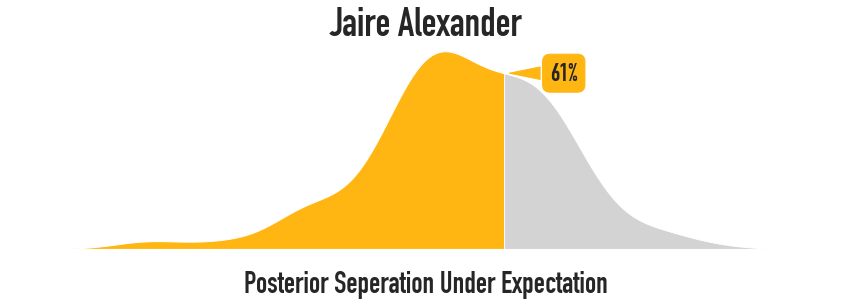

In [84]:
NAME = 'Jaire Alexander'

sepue_df_sub = sepue_df[sepue_df['displayName']==NAME]

CUTOFF = sepue_df_sub.iloc[0,]['sepue']

plt.figure(figsize=(15,4))
sns.set_style("white")
plt.box(on=None)
ax = sns.kdeplot(sepue_df.sepue, palette=('RdYlGn'))
ax.set(xticklabels=[], 
      yticklabels=[])
line = ax.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax.get_lines()[0].remove()
ax.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax.set_title(NAME, 
            font='DIN Condensed', fontsize=40)
ax.set_xlabel("Posterior Seperation Under Expectation",
             font='DIN Condensed', fontsize=30)
ax.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
ax.fill_between(x, y1=y, alpha=1, facecolor='#ffb612')
ax.annotate('61%', xy=(CUTOFF, y[y.shape[0]-1]),
           xycoords='data', xytext=(70, 0),
           textcoords='offset points', font='DIN Condensed', size=25, 
           ha='right', va='center', 
           bbox=dict(boxstyle='round', alpha=1, color='#ffb612'),
           arrowprops=dict(arrowstyle='wedge,tail_width=0.5',
                          alpha=1, color='#ffb612'));
print('PERCENTILE:', proportion)

# % OF TRACKED PLAYS TARGETED VS. ROUTES DEFENDED

In [90]:
wrdb_cov = pd.read_csv('wr_db_both_coverage.csv')

wrdb_cov

,wr_x,wr_y,wrId,gameId,playId,frameId,dbId,db_x,db_y,db_dir
0,28.62,9.14,2495454.0,2018090600,75,6,2555383.0,35.99,9.82,123.91
1,28.62,9.15,2495454.0,2018090600,75,7,2555383.0,36.00,9.82,139.99
2,28.62,9.15,2495454.0,2018090600,75,8,2555383.0,36.04,9.84,217.47
3,28.62,9.16,2495454.0,2018090600,75,9,2555383.0,36.05,9.85,221.62
4,28.62,9.16,2495454.0,2018090600,75,10,2555383.0,36.07,9.85,229.18
...,...,...,...,...,...,...,...,...,...,...
1473202,63.05,37.30,2558856.0,2018123015,4104,48,2495504.0,65.37,38.84,155.55
1473203,63.28,36.74,2558856.0,2018123015,4104,49,2495504.0,65.63,38.21,160.11
1473204,63.48,36.16,2558856.0,2018123015,4104,50,2495504.0,65.84,37.55,164.55
1473205,63.64,35.56,2558856.0,2018123015,4104,51,2495504.0,65.99,36.87,168.84


In [91]:
# get targeted player 
wrdb_cov = pd.merge(wrdb_cov[['wrId', 'gameId', 'playId', 'dbId']].drop_duplicates(), 
         targets[targets.targetNflId.notnull()],
         how='inner', on=['gameId', 'playId']) 

# define is target WR
wrdb_cov['isTarget'] = np.where(wrdb_cov['wrId']==wrdb_cov['targetNflId'], 1, 0)

# summarize WR target %
wr_target_pct = wrdb_cov[['wrId', 'isTarget']].groupby('wrId').agg('mean').reset_index()

# rename columns
wr_target_pct.columns = ['wrId', 'wr_target_pct']

# merge wr target %
wrdb_cov = pd.merge(wrdb_cov, wr_target_pct,
                   how='inner', on='wrId')

# wr target under expectation
wrdb_cov['tarue'] = wrdb_cov.wr_target_pct - wrdb_cov.isTarget

# calcualte db targets under expectation
db_tar = wrdb_cov[['dbId', 'tarue']].groupby('dbId').agg('mean').reset_index()

db_tar

,dbId,tarue
0,306.0,0.089795
1,1302.0,-0.021464
2,2307.0,-0.054364
3,4365.0,-0.016991
4,71251.0,-0.040797
...,...,...
325,2561340.0,-0.116191
326,2561417.0,-0.105406
327,2561469.0,-0.257070
328,2561527.0,-0.043089


In [92]:
# # find unique snaps played
# snaps_covered = wrdb_cov[['gameId', 'playId', 'dbId']].drop_duplicates()

# # count unique snaps
# snaps_covered = snaps_covered[['dbId', 'gameId']].groupby('dbId').agg('count').reset_index().query('gameId>25') 

# # rename columns 
# snaps_covered.columns = ['dbId', 'routes_covered']

# snaps_covered

In [93]:
# # merge to find targeted receiver
# wrdb_tar = pd.merge(wrdb_cov[['wrId', 'dbId', 'gameId', 'playId']], targets,
#         how='inner', on=['playId', 'gameId']).drop_duplicates()

# # subset to targeted WR and their shadowing DB
# wrdb_tar = wrdb_tar[wrdb_tar['wrId']==wrdb_tar['targetNflId']]

In [104]:
# # targets defended per DB
# db_tar = wrdb_tar[['dbId', 'gameId']].groupby('dbId').agg('count').reset_index()

# # rename columns
# db_tar.columns = ['dbId', 'targets_covered']

# # merge w/ routes covered
# db_tar = pd.merge(db_tar, snaps_covered,
#         how='inner', on='dbId')

# # calculate % of routes covered that were targeted
# db_tar['pct_targeted'] = db_tar.targets_covered / db_tar.routes_covered



# merge w/ DB player data
db_tar = pd.merge(db_tar, players,
                 how='inner', left_on='dbId', right_on='nflId') # .query('pct_targeted<.5')

# db_tar

In [87]:
# db_tar.to_csv('db_tarue.csv', index=False) 
db_tar = pd.merge(pd.read_csv('db_tarue.csv'),
                 players,
                 how='inner', left_on='dbId',
                 right_on='nflId')

In [89]:
db_tar.query('displayName=="Marcus Peters"')

,dbId,tarue,nflId,height,weight,birthDate,collegeName,position,displayName,age
142,2552488.0,0.016368,2552488,72,197,1993-01-09,Washington,CB,Marcus Peters,26


PERCENTILE: 0.64


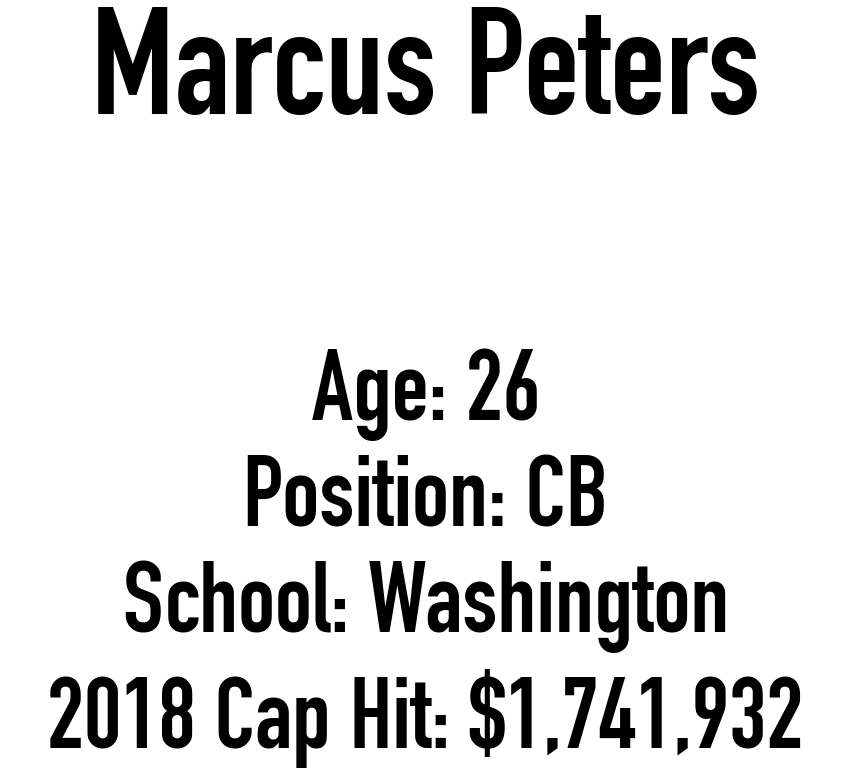

In [90]:
t_col = '#241773'
p_col = '#000000'
NAME = "Marcus Peters"

db_tar_sub = db_tar[db_tar['displayName']==NAME]

CUTOFF = db_tar_sub.iloc[0,]['tarue']

plt.figure(figsize=(15,4))
sns.set_style("white")
plt.box(on=None)
ax = sns.kdeplot(db_tar.tarue, palette=('RdYlGn'))
ax.set(xticklabels=[], 
      yticklabels=[])
line = ax.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax.get_lines()[0].remove()
# ax.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax.set_title(NAME, 
            font='DIN Condensed', fontsize=150, color=p_col)
ax.set_xlabel("Age: 26\nPosition: CB\nSchool: Washington\n2018 Cap Hit: $1,741,932",
             font='DIN Condensed', fontsize=100, color=p_col)
ax.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
# ax.fill_between(x, y1=y, alpha=1, facecolor='#ffb612')
# ax.annotate('52p', xy=(CUTOFF, y[y.shape[0]-1]),
#            xycoords='data', xytext=(120, 0),
#            textcoords='offset points', font='DIN Condensed', size=25, 
#            ha='right', va='center', 
#            bbox=dict(boxstyle='round', alpha=1, color='#ffb612'),
#            arrowprops=dict(arrowstyle='wedge,tail_width=0.5',
#                           alpha=1, color='#ffb612'));
plt.savefig('peters_text.png', dpi=600);
print('PERCENTILE:', proportion)

PERCENTILE: 0.675


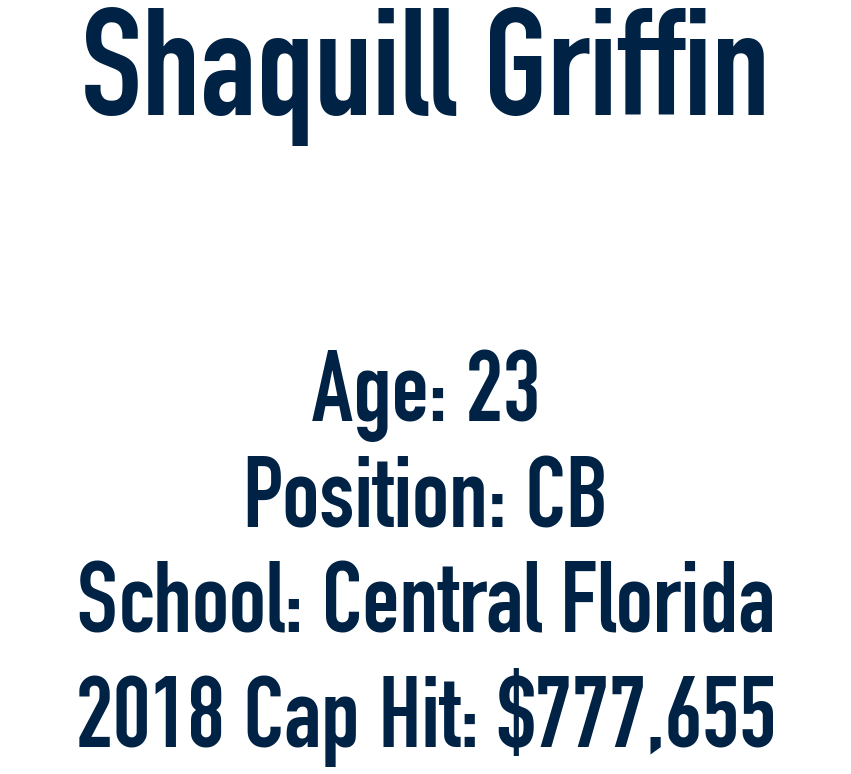

In [161]:
NAME = 'Shaquill Griffin'

db_tar_sub = db_tar[db_tar['displayName']==NAME]

CUTOFF = db_tar_sub.iloc[0,]['tarue']

plt.figure(figsize=(15,4))
sns.set_style("white")
plt.box(on=None)
ax = sns.kdeplot(db_tar.tarue, palette=('RdYlGn'))
ax.set(xticklabels=[], 
      yticklabels=[])
line = ax.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax.get_lines()[0].remove()
# ax.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax.set_title(NAME, 
            font='DIN Condensed', fontsize=150, color='#002244')
ax.set_xlabel("Age: 23\nPosition: CB\nSchool: Central Florida\n2018 Cap Hit: $777,655",
             font='DIN Condensed', fontsize=100, color='#002244')
ax.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
# ax.fill_between(x, y1=y, alpha=1, facecolor='#ffb612')
# ax.annotate('52p', xy=(CUTOFF, y[y.shape[0]-1]),
#            xycoords='data', xytext=(120, 0), 
#            textcoords='offset points', font='DIN Condensed', size=25, 
#            ha='right', va='center', 
#            bbox=dict(boxstyle='round', alpha=1, color='#ffb612'),
#            arrowprops=dict(arrowstyle='wedge,tail_width=0.5',
#                           alpha=1, color='#ffb612'));
plt.savefig('griffin_text.png', dpi=600);
print('PERCENTILE:', proportion)

# GMM / SALARY VALUE

In [17]:
db_money = pd.read_csv('db_money.csv') # load salaries
sepue_df = pd.read_csv('sepue_df.csv') # load seperation under expectation
# db_targets = pd.read_csv('db_route_targets.csv') # load targets/routes per DB
tarue_df = pd.read_csv('db_tarue.csv') # WR targets under expectation
cpue_df = pd.read_csv('cpoe_post_df.csv') # load completion % under expectation
yacue_df = pd.read_csv('yacue_post_df.csv') # load yac under expectation

In [18]:
players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName,age
0,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant,28
1,2539653,70,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford,30
2,2543850,69,186,1991-12-18,Purdue,SS,Ricardo Allen,27
3,2555162,73,227,1994-11-04,Louisiana State,MLB,Deion Jones,24
4,2555255,75,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell,25


In [19]:
db_money = db_money[['Player', 'Team', 'pos', 'cap']]
db_money.head()

,Player,Team,pos,cap
0,Josh Norman,Washington,CB,16937500
1,A.J. Bouye,Jaguars,CB,15500000
2,Patrick Peterson,Cardinals,CB,14956966
3,Xavier Rhodes,Vikings,CB,13400000
4,Jimmy Smith,Ravens,CB,13233040


In [20]:
sepue_df = sepue_df[['dbId', 'sepue']]
sepue_df.head()

,dbId,sepue
0,2558176.0,-3.035254
1,2552385.0,-3.014787
2,2495613.0,-2.779191
3,2543830.0,-2.319242
4,2556278.0,-2.179371


In [21]:
tarue_df.head()

,dbId,tarue
0,306.0,0.089795
1,1302.0,-0.021464
2,2307.0,-0.054364
3,4365.0,-0.016991
4,71251.0,-0.040797


In [22]:
cpue_df = cpue_df[['def_nflId', 'icpoe_post']]
cpue_df.columns = ['dbId', 'cpue']
cpue_df.head()

,dbId,cpue
0,2533049.0,-0.173048
1,2543592.0,-0.162017
2,2539243.0,-0.140523
3,2561132.0,-0.137640
4,2560908.0,-0.135014


In [23]:
yacue_df = yacue_df[['def_nflId', 'yacue_post']]
yacue_df.columns = ['dbId', 'yacue_post']
yacue_df.head()

,dbId,yacue_post
0,2560755.0,-2.671282
1,2558136.0,-2.599251
2,2543505.0,-2.141220
3,2553637.0,-1.935959
4,2552434.0,-1.901738


In [24]:
gmm_data = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(yacue_df, # yac under expectation
        cpue_df, # completion % under expectation
        how='inner', on='dbId'), tarue_df, # wr targets under expectation
         how='inner', on='dbId'), sepue_df, # seperation under expectation
         how='inner', on='dbId'), players, # player info
         how='inner', left_on='dbId', right_on='nflId'), db_money, # salary info
         how='inner', left_on='displayName', right_on='Player')[['dbId', 'yacue_post',
                                                                'cpue', 'tarue',
                                                                'sepue', 'height', 
                                                                'weight', 'collegeName',
                                                                'pos', 'Player', 'age', 
                                                                'cap', 'Team']]

gmm_data

,dbId,yacue_post,cpue,tarue,sepue,height,weight,collegeName,pos,Player,age,cap,Team
0,2560755.0,-2.671282,0.081869,-0.014051,0.708118,72,196,Iowa,CB,Josh Jackson,22,1137473,Packers
1,2558136.0,-2.599251,-0.012873,0.020926,-0.240624,72,204,UCLA,CB,Fabian Moreau,24,794348,Washington
2,2543505.0,-2.141220,-0.016347,0.016396,-0.577959,71,194,Ohio State,CB,Bradley Roby,26,8526000,Broncos
3,2553637.0,-1.935959,0.050098,-0.013832,0.096914,71,190,Tennessee,CB,Justin Coleman,25,2914000,Seahawks
4,2552434.0,-1.901738,0.031691,0.006475,-0.363356,71,192,Memphis,S,Bobby McCain,25,1502472,Dolphins
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,2540288.0,1.683760,0.119837,-0.014884,0.643776,72,190,Mississippi State,CB,Darius Slay,28,6126269,Lions
75,2539334.0,1.830025,0.026306,-0.012169,0.363755,72,190,Washington,CB,Desmond Trufant,28,12900000,Falcons
76,2541162.0,1.880703,0.017144,-0.016946,-0.170337,72,191,Central Florida,CB,A.J. Bouye,27,15500000,Jaguars
77,2533062.0,1.888094,0.117449,0.029376,0.933490,73,202,South Carolina,CB,Stephon Gilmore,28,8887500,Patriots


In [25]:
# select features
X = gmm_data[['yacue_post', 'cpue', 'sepue', #  'age', 
              'tarue']] 

# normalize data
X = (X - X.mean()) / X.std()

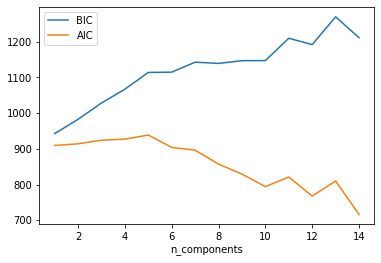

In [26]:
n_components = np.arange(1, 15)
models = [GaussianMixture(n, covariance_type='full', random_state=2).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [27]:
# fit Gaussian Mixture Model
K = 6
gmm = GaussianMixture(K, covariance_type='full', random_state=2).fit(X)

# get cluster responsibility probabilities
preds = pd.DataFrame(gmm.predict_proba(X))

# get class assignments
preds['class'] = gmm.predict(X) + 1

# rename columns
preds.columns = ['c'+str(i) for i in range(1, K+1)]+ ['class'] 

preds

,c1,c2,c3,c4,c5,c6,class
0,2.824540e-22,9.999610e-01,7.800069e-07,3.818685e-05,4.462048e-14,0.000000e+00,2
1,6.421398e-32,1.078335e-09,1.542555e-05,9.999846e-01,4.123150e-12,3.197365e-203,4
2,1.264477e-28,3.700393e-10,3.260073e-06,9.999967e-01,1.633201e-11,2.551553e-85,4
3,2.706835e-16,8.975937e-01,2.949527e-04,1.021065e-01,4.839489e-06,0.000000e+00,2
4,7.421917e-22,1.352693e-03,2.147269e-04,9.984325e-01,7.080999e-08,0.000000e+00,4
...,...,...,...,...,...,...,...
74,9.968795e-01,6.461432e-08,5.280760e-04,1.514091e-11,2.592346e-03,0.000000e+00,1
75,9.929965e-01,3.180939e-05,6.968704e-03,3.014883e-06,3.010428e-11,0.000000e+00,1
76,9.987380e-01,1.049013e-03,2.128703e-04,1.622368e-07,4.350259e-17,0.000000e+00,1
77,5.180707e-02,1.820650e-06,9.481898e-01,5.158801e-10,1.260180e-06,0.000000e+00,3


In [28]:
# concat data and preds
gmm_data = pd.concat([gmm_data, preds], axis=1)

gmm_data

,dbId,yacue_post,cpue,tarue,sepue,height,weight,collegeName,pos,Player,age,cap,Team,c1,c2,c3,c4,c5,c6,class
0,2560755.0,-2.671282,0.081869,-0.014051,0.708118,72,196,Iowa,CB,Josh Jackson,22,1137473,Packers,2.824540e-22,9.999610e-01,7.800069e-07,3.818685e-05,4.462048e-14,0.000000e+00,2
1,2558136.0,-2.599251,-0.012873,0.020926,-0.240624,72,204,UCLA,CB,Fabian Moreau,24,794348,Washington,6.421398e-32,1.078335e-09,1.542555e-05,9.999846e-01,4.123150e-12,3.197365e-203,4
2,2543505.0,-2.141220,-0.016347,0.016396,-0.577959,71,194,Ohio State,CB,Bradley Roby,26,8526000,Broncos,1.264477e-28,3.700393e-10,3.260073e-06,9.999967e-01,1.633201e-11,2.551553e-85,4
3,2553637.0,-1.935959,0.050098,-0.013832,0.096914,71,190,Tennessee,CB,Justin Coleman,25,2914000,Seahawks,2.706835e-16,8.975937e-01,2.949527e-04,1.021065e-01,4.839489e-06,0.000000e+00,2
4,2552434.0,-1.901738,0.031691,0.006475,-0.363356,71,192,Memphis,S,Bobby McCain,25,1502472,Dolphins,7.421917e-22,1.352693e-03,2.147269e-04,9.984325e-01,7.080999e-08,0.000000e+00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,2540288.0,1.683760,0.119837,-0.014884,0.643776,72,190,Mississippi State,CB,Darius Slay,28,6126269,Lions,9.968795e-01,6.461432e-08,5.280760e-04,1.514091e-11,2.592346e-03,0.000000e+00,1
75,2539334.0,1.830025,0.026306,-0.012169,0.363755,72,190,Washington,CB,Desmond Trufant,28,12900000,Falcons,9.929965e-01,3.180939e-05,6.968704e-03,3.014883e-06,3.010428e-11,0.000000e+00,1
76,2541162.0,1.880703,0.017144,-0.016946,-0.170337,72,191,Central Florida,CB,A.J. Bouye,27,15500000,Jaguars,9.987380e-01,1.049013e-03,2.128703e-04,1.622368e-07,4.350259e-17,0.000000e+00,1
77,2533062.0,1.888094,0.117449,0.029376,0.933490,73,202,South Carolina,CB,Stephon Gilmore,28,8887500,Patriots,5.180707e-02,1.820650e-06,9.481898e-01,5.158801e-10,1.260180e-06,0.000000e+00,3


In [29]:
# get cluster mean salary
class_cap_mean = gmm_data[['cap', 'class']].groupby('class').agg('mean').reset_index() 

class_cap_mean

,class,cap
0,1,5.982310e+06
1,2,4.561370e+06
2,3,5.336295e+06
3,4,2.639643e+06
4,5,2.333673e+06
5,6,3.087079e+06


In [30]:
# save class means as variables
c1s = class_cap_mean[class_cap_mean['class']==1].iloc[0,]['cap']
c2s = class_cap_mean[class_cap_mean['class']==2].iloc[0,]['cap']
c3s = class_cap_mean[class_cap_mean['class']==3].iloc[0,]['cap']
c4s = class_cap_mean[class_cap_mean['class']==4].iloc[0,]['cap']
c5s = class_cap_mean[class_cap_mean['class']==5].iloc[0,]['cap']
c6s = class_cap_mean[class_cap_mean['class']==6].iloc[0,]['cap']
# c7s = class_cap_mean[class_cap_mean['class']==7].iloc[0,]['cap']
# c8s = class_cap_mean[class_cap_mean['class']==8].iloc[0,]['cap']
# c9s = class_cap_mean[class_cap_mean['class']==9].iloc[0,]['cap']
# c10s = class_cap_mean[class_cap_mean['class']==10].iloc[0,]['cap']

gmm_data['exp_cap'] = gmm_data.c1*c1s + gmm_data.c2*c2s + gmm_data.c3*c3s + gmm_data.c4*c4s + gmm_data.c5*c5s + gmm_data.c6*c6s # + gmm_data.c7*c7s + gmm_data.c8*c8s + gmm_data.c9*c9s + gmm_data.c10*c10s   

gmm_data['capue'] = gmm_data.exp_cap - gmm_data.cap

gmm_data

,dbId,yacue_post,cpue,tarue,sepue,height,weight,collegeName,pos,Player,...,Team,c1,c2,c3,c4,c5,c6,class,exp_cap,capue
0,2560755.0,-2.671282,0.081869,-0.014051,0.708118,72,196,Iowa,CB,Josh Jackson,...,Packers,2.824540e-22,9.999610e-01,7.800069e-07,3.818685e-05,4.462048e-14,0.000000e+00,2,4.561297e+06,3.423824e+06
1,2558136.0,-2.599251,-0.012873,0.020926,-0.240624,72,204,UCLA,CB,Fabian Moreau,...,Washington,6.421398e-32,1.078335e-09,1.542555e-05,9.999846e-01,4.123150e-12,3.197365e-203,4,2.639684e+06,1.845336e+06
2,2543505.0,-2.141220,-0.016347,0.016396,-0.577959,71,194,Ohio State,CB,Bradley Roby,...,Broncos,1.264477e-28,3.700393e-10,3.260073e-06,9.999967e-01,1.633201e-11,2.551553e-85,4,2.639652e+06,-5.886348e+06
3,2553637.0,-1.935959,0.050098,-0.013832,0.096914,71,190,Tennessee,CB,Justin Coleman,...,Seahawks,2.706835e-16,8.975937e-01,2.949527e-04,1.021065e-01,4.839489e-06,0.000000e+00,2,4.365367e+06,1.451367e+06
4,2552434.0,-1.901738,0.031691,0.006475,-0.363356,71,192,Memphis,S,Bobby McCain,...,Dolphins,7.421917e-22,1.352693e-03,2.147269e-04,9.984325e-01,7.080999e-08,0.000000e+00,4,2.642821e+06,1.140349e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,2540288.0,1.683760,0.119837,-0.014884,0.643776,72,190,Mississippi State,CB,Darius Slay,...,Lions,9.968795e-01,6.461432e-08,5.280760e-04,1.514091e-11,2.592346e-03,0.000000e+00,1,5.972510e+06,-1.537586e+05
75,2539334.0,1.830025,0.026306,-0.012169,0.363755,72,190,Washington,CB,Desmond Trufant,...,Falcons,9.929965e-01,3.180939e-05,6.968704e-03,3.014883e-06,3.010428e-11,0.000000e+00,1,5.977753e+06,-6.922247e+06
76,2541162.0,1.880703,0.017144,-0.016946,-0.170337,72,191,Central Florida,CB,A.J. Bouye,...,Jaguars,9.987380e-01,1.049013e-03,2.128703e-04,1.622368e-07,4.350259e-17,0.000000e+00,1,5.980682e+06,-9.519318e+06
77,2533062.0,1.888094,0.117449,0.029376,0.933490,73,202,South Carolina,CB,Stephon Gilmore,...,Patriots,5.180707e-02,1.820650e-06,9.481898e-01,5.158801e-10,1.260180e-06,0.000000e+00,3,5.369758e+06,-3.517742e+06


In [31]:
# gmm_data.to_csv('gmm_done.csv', index=False)

In [32]:
gmm_data[['yacue_post', 'cpue', 'tarue', 'sepue', 'age', 'Player', 'cap', 'exp_cap', 'capue', 'pos']].sort_values('capue', 
                                                                                                       ascending=False).round(2).head(20)

,yacue_post,cpue,tarue,sepue,age,Player,cap,exp_cap,capue,pos
58,1.02,-0.02,-0.03,-0.01,26,Briean Boddy-Calhoun,630000,5981839.87,5351839.87,S
48,0.45,0.02,-0.04,-0.33,24,Mike Hilton,555000,5885289.40,5330289.40,CB
68,1.33,0.04,-0.05,0.47,23,Chidobe Awuzie,973541,5982227.89,5008686.89,CB
78,2.34,0.16,-0.02,-0.43,25,Ronald Darby,1058139,5982308.22,4924169.22,CB
23,-0.37,0.03,0.02,0.77,23,Tre Flowers,554681,5329799.32,4775118.32,CB
66,1.33,0.08,0.02,0.52,28,B.W. Webb,655000,5337663.15,4682663.15,CB
52,0.67,0.01,0.04,0.85,23,Shaquill Griffin,777655,5336292.85,4558637.85,CB
69,1.41,-0.07,0.01,1.04,24,Vonn Bell,1083354,5345129.27,4261775.27,S
18,-0.76,0.04,-0.04,-0.13,31,Shareece Wright,592941,4545769.74,3952828.74,CB
67,1.33,0.06,-0.01,0.57,22,Jaire Alexander,2191042,5968455.28,3777413.28,CB


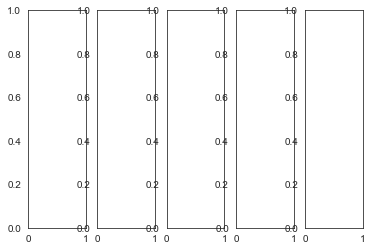

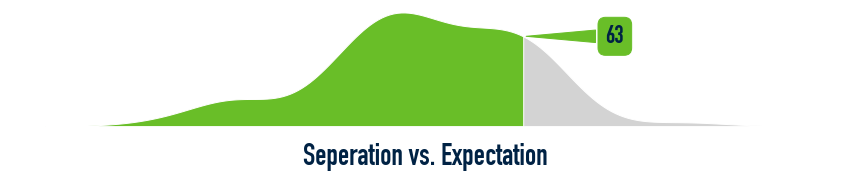

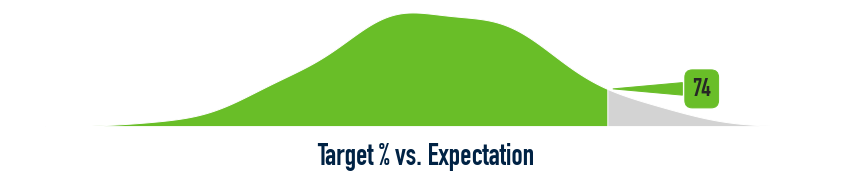

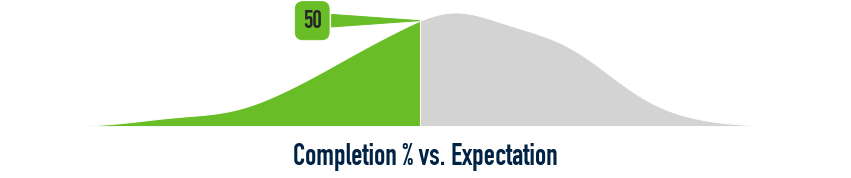

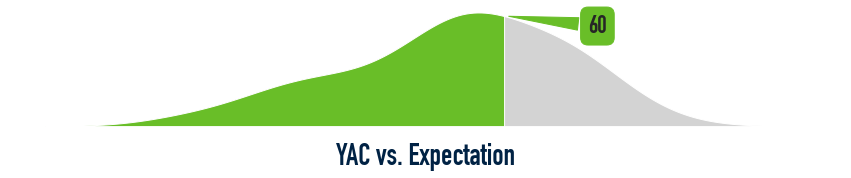

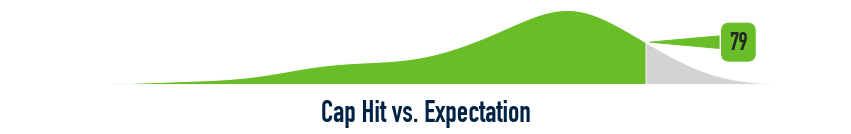

In [113]:
NAME = 'Shaquill Griffin'

f_h = 2.3
f_w = 15
p_col = '#69be28'
t_col = '#002244'

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

gmm_data_sub = gmm_data[gmm_data['Player']==NAME]

CUTOFF = gmm_data_sub.iloc[0,]['sepue'] 

plt.figure(figsize=(f_w,f_h))
sns.set_style("white")
plt.box(on=None)
ax1 = sns.kdeplot(gmm_data.sepue, palette=('RdYlGn'))
ax1.set(xticklabels=[], 
      yticklabels=[])
line = ax1.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax1.get_lines()[0].remove()
ax1.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax1.set_title("", 
            font='DIN Condensed', fontsize=40)
ax1.set_xlabel("Seperation vs. Expectation",
             font='DIN Condensed', fontsize=30, color=t_col)
ax1.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
ax1.fill_between(x, y1=y, alpha=1, facecolor=p_col)
ax1.annotate(str(round(proportion*100)), xy=(CUTOFF, y[y.shape[0]-1]),
           xycoords='data', xytext=(100, 0),
           textcoords='offset points', font='DIN Condensed', size=25, color=t_col, 
           ha='right', va='center', 
           bbox=dict(boxstyle='round', alpha=1, color=p_col),
           arrowprops=dict(arrowstyle='wedge,tail_width=0.5',
                          alpha=1, color=p_col))
plt.savefig('griffin_sep.png', dpi=600,  bbox_inches='tight')


CUTOFF = gmm_data_sub.iloc[0,]['tarue'] 

plt.figure(figsize=(f_w,f_h))
sns.set_style("white")
plt.box(on=None)
ax2 = sns.kdeplot(gmm_data.tarue, palette=('RdYlGn'))
ax2.set(xticklabels=[], 
      yticklabels=[])
line = ax2.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax2.get_lines()[0].remove()
ax2.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax2.set_title("", 
            font='DIN Condensed', fontsize=40)
ax2.set_xlabel("Target % vs. Expectation",
             font='DIN Condensed', fontsize=30, color=t_col)
ax2.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
ax2.fill_between(x, y1=y, alpha=1, facecolor=p_col)
ax2.annotate(str(round(proportion*100)), xy=(CUTOFF, y[y.shape[0]-1]),
           xycoords='data', xytext=(100, 0),
           textcoords='offset points', font='DIN Condensed', size=25, 
           ha='right', va='center', 
           bbox=dict(boxstyle='round', alpha=1, color=p_col),
           arrowprops=dict(arrowstyle='wedge,tail_width=0.5',
                          alpha=1, color=p_col))

plt.savefig('griffin_tar.png', dpi=600,  bbox_inches='tight')

CUTOFF = gmm_data_sub.iloc[0,]['cpue'] 

plt.figure(figsize=(f_w,f_h))
sns.set_style("white")
plt.box(on=None)
ax3 = sns.kdeplot(gmm_data.cpue, palette=('RdYlGn'))
ax3.set(xticklabels=[], 
      yticklabels=[])
line = ax3.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax3.get_lines()[0].remove()
ax3.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax3.set_title("", 
            font='DIN Condensed', fontsize=40)
ax3.set_xlabel("Completion % vs. Expectation",
             font='DIN Condensed', fontsize=30, color=t_col)
ax3.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
ax3.fill_between(x, y1=y, alpha=1, facecolor=p_col)
ax3.annotate(str(round(proportion*100)), xy=(CUTOFF, y[y.shape[0]-1]),
           xycoords='data', xytext=(-100, 0),
           textcoords='offset points', font='DIN Condensed', size=25, 
           ha='right', va='center', 
           bbox=dict(boxstyle='round', alpha=1, color=p_col),
           arrowprops=dict(arrowstyle='wedge,tail_width=0.5',
                          alpha=1, color=p_col))

plt.savefig('griffin_cp.png', dpi=600,  bbox_inches='tight')

CUTOFF = gmm_data_sub.iloc[0,]['yacue_post'] 

plt.figure(figsize=(f_w,f_h))
sns.set_style("white")
plt.box(on=None)
ax4 = sns.kdeplot(gmm_data.yacue_post, palette=('RdYlGn'))
ax4.set(xticklabels=[], 
      yticklabels=[])
line = ax4.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax4.get_lines()[0].remove()
ax4.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax4.set_title("", 
            font='DIN Condensed', fontsize=40)
ax4.set_xlabel("YAC vs. Expectation",
             font='DIN Condensed', fontsize=30, color=t_col)
ax4.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
ax4.fill_between(x, y1=y, alpha=1, facecolor=p_col)
ax4.annotate(str(round(proportion*100)), xy=(CUTOFF, y[y.shape[0]-1]),
           xycoords='data', xytext=(100, -10),
           textcoords='offset points', font='DIN Condensed', size=25, 
           ha='right', va='center', 
           bbox=dict(boxstyle='round', alpha=1, color=p_col),
           arrowprops=dict(arrowstyle='wedge,tail_width=0.5',
                          alpha=1, color=p_col))
plt.savefig('griffin_yac.png', dpi=600,  bbox_inches='tight')

CUTOFF = gmm_data_sub.iloc[0,]['capue'] 

plt.figure(figsize=(f_w,1.5))
sns.set_style("white")
plt.box(on=None)
ax5 = sns.kdeplot(gmm_data.capue, palette=('RdYlGn'))
ax5.set(xticklabels=[], 
      yticklabels=[])
line = ax5.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax5.get_lines()[0].remove()
ax5.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax5.set_title("", 
            font='DIN Condensed', fontsize=40)
ax5.set_xlabel("Cap Hit vs. Expectation",
             font='DIN Condensed', fontsize=30, color=t_col)
ax5.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
ax5.fill_between(x, y1=y, alpha=1, facecolor=p_col)
ax5.annotate(str(round(proportion*100)), xy=(CUTOFF, y[y.shape[0]-1]),
           xycoords='data', xytext=(100, 0),
           textcoords='offset points', font='DIN Condensed', size=25, 
           ha='right', va='center', 
           bbox=dict(boxstyle='round', alpha=1, color=p_col),
           arrowprops=dict(arrowstyle='wedge,tail_width=0.5',
                          alpha=1, color=p_col))

plt.savefig('griffin_money.png', dpi=600,  bbox_inches='tight');

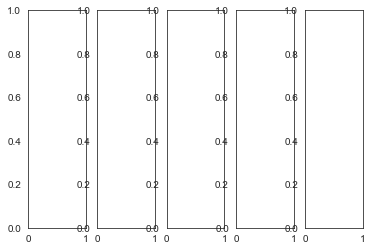

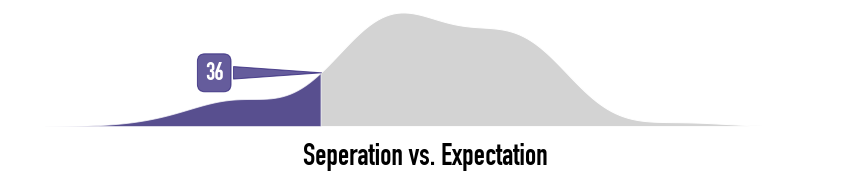

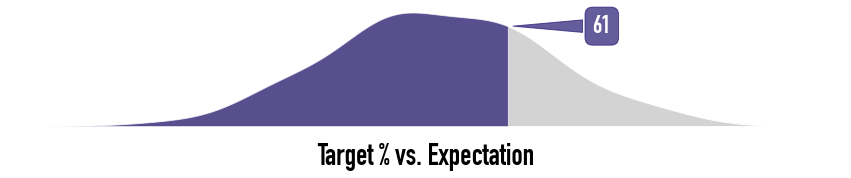

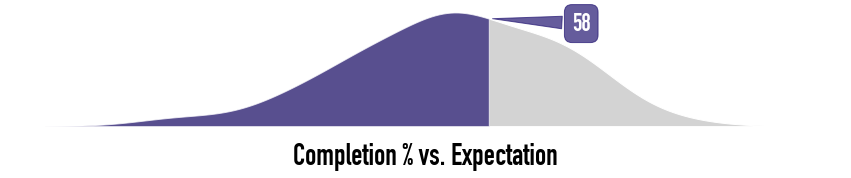

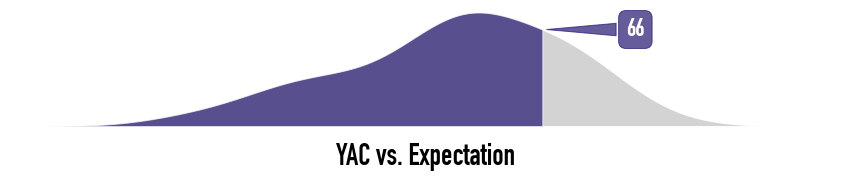

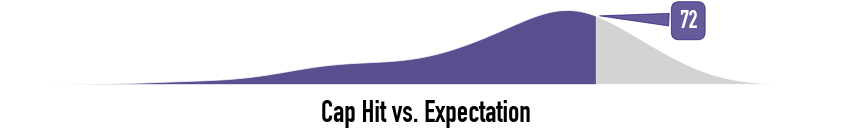

In [114]:
p_col = '#241773'
t_col = '#000000'
NAME = "Marcus Peters"

f_h = 2.3
f_w = 15


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
gmm_data_sub = gmm_data[gmm_data['Player']==NAME]

CUTOFF = gmm_data_sub.iloc[0,]['sepue'] 

plt.figure(figsize=(f_w,f_h))
sns.set_style("white")
plt.box(on=None)
ax1 = sns.kdeplot(gmm_data.sepue, palette=('RdYlGn'))
ax1.set(xticklabels=[], 
      yticklabels=[])
line = ax1.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax1.get_lines()[0].remove()
ax1.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax1.set_title("", 
            font='DIN Condensed', fontsize=40)
ax1.set_xlabel("Seperation vs. Expectation",
             font='DIN Condensed', fontsize=30, color=t_col)
ax1.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
ax1.fill_between(x, y1=y, alpha=.7, facecolor=p_col)
ax1.annotate(str(round(proportion*100)), xy=(CUTOFF, y[y.shape[0]-1]),
           xycoords='data', xytext=(-100, 0),
           textcoords='offset points', font='DIN Condensed', size=25, color='#ffffff', 
           ha='right', va='center', 
           bbox=dict(boxstyle='round', alpha=.7, color=p_col),
           arrowprops=dict(arrowstyle='wedge,tail_width=0.5', alpha=.7, color=p_col))
plt.savefig('peters_sep.png', dpi=600,  bbox_inches='tight')


CUTOFF = gmm_data_sub.iloc[0,]['tarue'] 

plt.figure(figsize=(f_w,f_h))
sns.set_style("white")
plt.box(on=None)
ax2 = sns.kdeplot(gmm_data.tarue, palette=('RdYlGn'))
ax2.set(xticklabels=[], 
      yticklabels=[])
line = ax2.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax2.get_lines()[0].remove()
ax2.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax2.set_title("", 
            font='DIN Condensed', fontsize=40)
ax2.set_xlabel("Target % vs. Expectation",
             font='DIN Condensed', fontsize=30, color=t_col)
ax2.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
ax2.fill_between(x, y1=y, alpha=.7, facecolor=p_col)
ax2.annotate(str(round(proportion*100)), xy=(CUTOFF, y[y.shape[0]-1]),
           xycoords='data', xytext=(100, 0),
           textcoords='offset points', font='DIN Condensed', size=25, color='#ffffff', 
           ha='right', va='center', 
           bbox=dict(boxstyle='round', alpha=.7, color=p_col),
           arrowprops=dict(arrowstyle='wedge,tail_width=0.5', alpha=.7, color=p_col))
plt.savefig('peters_tar.png', dpi=600,  bbox_inches='tight')

CUTOFF = gmm_data_sub.iloc[0,]['cpue'] 

plt.figure(figsize=(f_w,f_h))
sns.set_style("white")
plt.box(on=None)
ax3 = sns.kdeplot(gmm_data.cpue, palette=('RdYlGn'))
ax3.set(xticklabels=[], 
      yticklabels=[])
line = ax3.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax3.get_lines()[0].remove()
ax3.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax3.set_title("", 
            font='DIN Condensed', fontsize=40)
ax3.set_xlabel("Completion % vs. Expectation",
             font='DIN Condensed', fontsize=30, color=t_col)
ax3.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
ax3.fill_between(x, y1=y, alpha=.7, facecolor=p_col) 
ax3.annotate(str(round(proportion*100)), xy=(CUTOFF, y[y.shape[0]-1]),
           xycoords='data', xytext=(100, -5),
           textcoords='offset points', font='DIN Condensed', size=25, color='#ffffff', 
           ha='right', va='center', 
           bbox=dict(boxstyle='round', alpha=.7, color=p_col),
           arrowprops=dict(arrowstyle='wedge,tail_width=0.5', alpha=.7, color=p_col))
plt.savefig('peters_cp.png', dpi=600,  bbox_inches='tight')

CUTOFF = gmm_data_sub.iloc[0,]['yacue_post'] 

plt.figure(figsize=(f_w,f_h))
sns.set_style("white")
plt.box(on=None)
ax4 = sns.kdeplot(gmm_data.yacue_post, palette=('RdYlGn'))
ax4.set(xticklabels=[], 
      yticklabels=[])
line = ax4.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax4.get_lines()[0].remove()
ax4.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax4.set_title("", 
            font='DIN Condensed', fontsize=40)
ax4.set_xlabel("YAC vs. Expectation",
             font='DIN Condensed', fontsize=30, color=t_col)
ax4.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
ax4.fill_between(x, y1=y, alpha=.7, facecolor=p_col)
ax4.annotate(str(round(proportion*100)), xy=(CUTOFF, y[y.shape[0]-1]),
           xycoords='data', xytext=(100, 0),
           textcoords='offset points', font='DIN Condensed', size=25, color='#ffffff', 
           ha='right', va='center', 
           bbox=dict(boxstyle='round', alpha=.7, color=p_col),
           arrowprops=dict(arrowstyle='wedge,tail_width=0.5', alpha=.7, color=p_col))
plt.savefig('peters_yac.png', dpi=600,  bbox_inches='tight')

CUTOFF = gmm_data_sub.iloc[0,]['capue'] 

plt.figure(figsize=(f_w,1.5))
sns.set_style("white")
plt.box(on=None)
ax5 = sns.kdeplot(gmm_data.capue, palette=('RdYlGn'))
ax5.set(xticklabels=[], 
      yticklabels=[])
line = ax5.get_lines()[-1]
x, y = line.get_data()
proportion = x.shape[0]
ax5.get_lines()[0].remove()
ax5.fill_between(x, y1=y, alpha=1, facecolor='lightgray')
mask = x < CUTOFF
x, y = x[mask], y[mask]
proportion = x.shape[0] / proportion
ax5.set_title("", 
            font='DIN Condensed', fontsize=40)
ax5.set_xlabel("Cap Hit vs. Expectation",
             font='DIN Condensed', fontsize=30, color=t_col)
ax5.set_ylabel("", 
             font='DIN Condensed', fontsize=30)
ax5.fill_between(x, y1=y, alpha=.7, facecolor=p_col)
ax5.annotate(str(round(proportion*100)), xy=(CUTOFF, y[y.shape[0]-1]),
           xycoords='data', xytext=(100, -5),
           textcoords='offset points', font='DIN Condensed', size=25, color='#ffffff', 
           ha='right', va='center', 
           bbox=dict(boxstyle='round', alpha=.7, color=p_col),
           arrowprops=dict(arrowstyle='wedge,tail_width=0.5', alpha=.7, color=p_col))
plt.savefig('peters_money.png', dpi=600,  bbox_inches='tight');